In [1]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import h5py as h5

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install ipython-autotime

#%load_ext autotime

In [3]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [3]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [4]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [5]:
tqdm = partial(tqdm, position=0, leave=True)

In [6]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/MAP-20210707T092105Z-001/MAP"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/MAP-20210707T092105Z-001/MAP/'

#centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []


#Change this according to your dataset split

for file in files_all[:61]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[60:120]:
  right_files_path.append(folder_path + file)

In [7]:
print(len(files_all))

176


In [8]:
from multiprocessing import Pool

In [9]:
import multiprocessing
print(multiprocessing.cpu_count())


2


In [10]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC )
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC )
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 60/60 [00:57<00:00,  1.04it/s]


In [11]:
Dataset = 'MAP Dataset'

In [12]:
f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_bgr_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 7.585329294204712 [s] ... size 887.702213 MB


In [13]:
f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_gray_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 17.441935062408447 [s] ... size 1183.602268 MB


In [14]:
del images_left_bgr,images_right_bgr

In [15]:
from timeit import default_timer as timer

In [16]:
time_all = []

In [17]:
num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_fast = []
num_kps_freak = []
num_kps_gftt = []
num_kps_star = []
num_kps_surf = []
num_kps_rootsift = []
num_kps_superpoint = []


BRISK

In [18]:
Threshl=60;
Octaves=6; 
#PatternScales=1.0f;

start = timer()

brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  #points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  #points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:10<00:00,  1.18s/it]


In [19]:
for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk[1:]):
  num_kps_brisk.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 28126.10it/s]


In [20]:
all_feat_brisk_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_brisk):
  all_feat_brisk_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_left_each.append(temp)
  all_feat_brisk_left.append(all_feat_brisk_left_each)

In [21]:
all_feat_brisk_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_brisk):
  all_feat_brisk_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_right_each.append(temp)
  all_feat_brisk_right.append(all_feat_brisk_right_each)

In [22]:
del keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk

In [23]:
import pickle
Fdb = open('all_feat_brisk_left.dat', 'wb')
pickle.dump(all_feat_brisk_left,Fdb,-1)
Fdb.close()

In [24]:
import pickle
Fdb = open('all_feat_brisk_right.dat', 'wb')
pickle.dump(all_feat_brisk_right,Fdb,-1)
Fdb.close()

In [25]:
del Fdb, all_feat_brisk_left, all_feat_brisk_right

MSER + SIFT

In [26]:
start = timer()

mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  #points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  #points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [05:51<00:00,  5.86s/it]


In [27]:
for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser[1:]):
  num_kps_mser.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 144010.44it/s]


In [28]:
all_feat_mser_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_mser):
  all_feat_mser_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_left_each.append(temp)
  all_feat_mser_left.append(all_feat_mser_left_each)

In [29]:
all_feat_mser_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_mser):
  all_feat_mser_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_right_each.append(temp)
  all_feat_mser_right.append(all_feat_mser_right_each)

In [30]:
del keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser

In [31]:
import pickle
Fdb = open('all_feat_mser_left.dat', 'wb')
pickle.dump(all_feat_mser_left,Fdb,-1)
Fdb.close()

In [32]:
import pickle
Fdb = open('all_feat_mser_right.dat', 'wb')
pickle.dump(all_feat_mser_right,Fdb,-1)
Fdb.close()

In [33]:
del Fdb, all_feat_mser_left, all_feat_mser_right

FAST + SIFT

In [ ]:
'''
start = timer()


fast = cv2.FastFeatureDetector_create(threshold=40)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]

keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_fast.append(kpt)
  descriptors_all_left_fast.append(descrip)
  #points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_fast.append(kpt)
  descriptors_all_right_fast.append(descrip)
  #points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast[1:]):
  num_kps_fast.append(len(j))

In [37]:
'''
all_feat_fast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_fast):
  all_feat_fast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_left_each.append(temp)
  all_feat_fast_left.append(all_feat_fast_left_each)

In [ ]:
'''
all_feat_fast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_fast):
  all_feat_fast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_right_each.append(temp)
  all_feat_fast_right.append(all_feat_fast_right_each)

In [ ]:
'''
del keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'wb')
pickle.dump(all_feat_fast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'wb')
pickle.dump(all_feat_fast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_fast_left, all_feat_fast_right

GFTT + SIFT

In [34]:
start = timer()

gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  #points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  #points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:17<00:00,  3.41it/s]


In [35]:
for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt[1:]):
  num_kps_gftt.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 257846.56it/s]


In [36]:
all_feat_gftt_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_gftt):
  all_feat_gftt_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_left_each.append(temp)
  all_feat_gftt_left.append(all_feat_gftt_left_each)

In [37]:
all_feat_gftt_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_gftt):
  all_feat_gftt_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_right_each.append(temp)
  all_feat_gftt_right.append(all_feat_gftt_right_each)

In [38]:
del keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt

In [39]:
import pickle
Fdb = open('all_feat_gftt_left.dat', 'wb')
pickle.dump(all_feat_gftt_left,Fdb,-1)
Fdb.close()

In [40]:
import pickle
Fdb = open('all_feat_gftt_right.dat', 'wb')
pickle.dump(all_feat_gftt_right,Fdb,-1)
Fdb.close()

In [41]:
del Fdb, all_feat_gftt_left, all_feat_gftt_right

DAISY+SIFT

In [42]:
start = timer()

daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  #points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  #points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:26<00:00,  1.44s/it]


In [43]:
for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy[1:]):
  num_kps_daisy.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 41120.63it/s]


In [44]:
all_feat_daisy_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_daisy):
  all_feat_daisy_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_left_each.append(temp)
  all_feat_daisy_left.append(all_feat_daisy_left_each)

In [45]:
all_feat_daisy_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_daisy):
  all_feat_daisy_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_right_each.append(temp)
  all_feat_daisy_right.append(all_feat_daisy_right_each)

In [46]:
del keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy

In [47]:
import pickle
Fdb = open('all_feat_daisy_left.dat', 'wb')
pickle.dump(all_feat_daisy_left,Fdb,-1)
Fdb.close()

In [48]:
import pickle
Fdb = open('all_feat_daisy_right.dat', 'wb')
pickle.dump(all_feat_daisy_right,Fdb,-1)
Fdb.close()

In [49]:
del Fdb, all_feat_daisy_left, all_feat_daisy_right

SIFT

In [50]:
print(len(left_files_path))

61


In [51]:
print(len(right_files_path))

60


In [52]:
# H5 file w/o compression
#t0=time.time()
#f=h5.File('drive/MyDrive/all_images_bgr_sift.h5','r')
#print('HDF5  w/o comp.: data shape =',len(f['data'][0]),time.time()-t0,'[s]')
#f.close()

In [53]:
# del f

In [54]:
start = timer()

sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  #points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  #points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:31<00:00,  2.53s/it]


In [55]:
for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift[1:]):
  num_kps_sift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 52406.96it/s]


In [56]:
all_feat_sift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_sift):
  all_feat_sift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_left_each.append(temp)
  all_feat_sift_left.append(all_feat_sift_left_each)

In [57]:
all_feat_sift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_sift):
  all_feat_sift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_right_each.append(temp)
  all_feat_sift_right.append(all_feat_sift_right_each)

In [58]:
del keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift

In [59]:
import pickle
Fdb = open('all_feat_sift_left.dat', 'wb')
pickle.dump(all_feat_sift_left,Fdb,-1)
Fdb.close()

In [60]:
import pickle
Fdb = open('all_feat_sift_right.dat', 'wb')
pickle.dump(all_feat_sift_right,Fdb,-1)
Fdb.close()

In [61]:
del Fdb, all_feat_sift_left, all_feat_sift_right

In [62]:
#del keypoints_all_right_sift, keypoints_all_left_sift, descriptors_all_right_sift, descriptors_all_left_sift, points_all_right_sift, points_all_left_sift

SURF

In [63]:
start = timer()

surf  = cv2.xfeatures2d.SURF_create(upright=1)
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  #points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  #points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:18<00:00,  2.32s/it]


In [64]:
for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf[1:]):
  num_kps_surf.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 154202.35it/s]


In [65]:
all_feat_surf_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surf):
  all_feat_surf_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_left_each.append(temp)
  all_feat_surf_left.append(all_feat_surf_left_each)

In [66]:
all_feat_surf_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surf):
  all_feat_surf_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_right_each.append(temp)
  all_feat_surf_right.append(all_feat_surf_right_each)

In [67]:
del keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf

In [68]:
import pickle
Fdb = open('all_feat_surf_left.dat', 'wb')
pickle.dump(all_feat_surf_left,Fdb,-1)
Fdb.close()

In [69]:
import pickle
Fdb = open('all_feat_surf_right.dat', 'wb')
pickle.dump(all_feat_surf_right,Fdb,-1)
Fdb.close()

In [70]:
del Fdb, all_feat_surf_left, all_feat_surf_right

Total Matches,Robust Matches and Homography Computation

In [71]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh, maxIters=3000)
    inliers = inliers.flatten()
    return H, inliers

In [72]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [73]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.75,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.knnMatch(lff1, lff,k=2)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  
  if len(inlier_matchset)<25:
    matches_4 = []
    ratio = 0.85
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
  
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [74]:
def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]

In [75]:
import pickle
Fdb = open('all_feat_brisk_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_brisk.append(keypoints_each)
  descriptors_all_left_brisk.append(descrip_each)

In [76]:
import pickle
Fdb = open('all_feat_brisk_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_brisk.append(keypoints_each)
  descriptors_all_right_brisk.append(descrip_each)

In [77]:
H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

images_left_bgr = []
images_right_bgr = []
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

  2%|▏         | 1/61 [00:07<07:44,  7.74s/it]


Number of matches 55677
Number of matches After Lowe's Ratio 1713
Number of Robust matches 1535




  3%|▎         | 2/61 [00:16<07:56,  8.08s/it]


Number of matches 57353
Number of matches After Lowe's Ratio 1735
Number of Robust matches 1522




  5%|▍         | 3/61 [00:25<07:58,  8.25s/it]


Number of matches 60333
Number of matches After Lowe's Ratio 1654
Number of Robust matches 1333




  7%|▋         | 4/61 [00:34<08:04,  8.49s/it]


Number of matches 60160
Number of matches After Lowe's Ratio 1425
Number of Robust matches 1240




  8%|▊         | 5/61 [00:43<08:10,  8.76s/it]


Number of matches 59732
Number of matches After Lowe's Ratio 116
Number of Robust matches 94




 10%|▉         | 6/61 [00:52<07:55,  8.64s/it]


Number of matches 50748
Number of matches After Lowe's Ratio 2993
Number of Robust matches 2672




 11%|█▏        | 7/61 [00:59<07:31,  8.35s/it]


Number of matches 49229
Number of matches After Lowe's Ratio 2029
Number of Robust matches 1902




 13%|█▎        | 8/61 [01:06<06:53,  7.80s/it]


Number of matches 44902
Number of matches After Lowe's Ratio 1835
Number of Robust matches 1693




 15%|█▍        | 9/61 [01:12<06:21,  7.34s/it]


Number of matches 42126
Number of matches After Lowe's Ratio 1982
Number of Robust matches 1863




 16%|█▋        | 10/61 [01:18<05:47,  6.81s/it]


Number of matches 41155
Number of matches After Lowe's Ratio 1833
Number of Robust matches 1763




 18%|█▊        | 11/61 [01:23<05:23,  6.46s/it]


Number of matches 38377
Number of matches After Lowe's Ratio 1892
Number of Robust matches 1776




 20%|█▉        | 12/61 [01:28<04:52,  5.96s/it]


Number of matches 39499
Number of matches After Lowe's Ratio 1941
Number of Robust matches 1751




 21%|██▏       | 13/61 [01:33<04:36,  5.77s/it]


Number of matches 37350
Number of matches After Lowe's Ratio 1825
Number of Robust matches 1810




 23%|██▎       | 14/61 [01:38<04:11,  5.35s/it]


Number of matches 35747
Number of matches After Lowe's Ratio 1773
Number of Robust matches 1748




 25%|██▍       | 15/61 [01:42<03:48,  4.98s/it]


Number of matches 34127
Number of matches After Lowe's Ratio 1660
Number of Robust matches 1617




 26%|██▌       | 16/61 [01:46<03:33,  4.75s/it]


Number of matches 31692
Number of matches After Lowe's Ratio 1483
Number of Robust matches 1464




 28%|██▊       | 17/61 [01:49<03:10,  4.34s/it]


Number of matches 28986
Number of matches After Lowe's Ratio 1199
Number of Robust matches 1136




 30%|██▉       | 18/61 [01:52<02:49,  3.94s/it]


Number of matches 28823
Number of matches After Lowe's Ratio 1149
Number of Robust matches 1131




 31%|███       | 19/61 [01:56<02:38,  3.78s/it]


Number of matches 26721
Number of matches After Lowe's Ratio 1142
Number of Robust matches 1115




 33%|███▎      | 20/61 [01:59<02:21,  3.46s/it]


Number of matches 27608
Number of matches After Lowe's Ratio 1121
Number of Robust matches 1056




 34%|███▍      | 21/61 [02:01<02:11,  3.28s/it]


Number of matches 27518
Number of matches After Lowe's Ratio 1203
Number of Robust matches 1132




 36%|███▌      | 22/61 [02:05<02:08,  3.30s/it]


Number of matches 28433
Number of matches After Lowe's Ratio 1160
Number of Robust matches 1137




 38%|███▊      | 23/61 [02:08<02:01,  3.19s/it]


Number of matches 26102
Number of matches After Lowe's Ratio 1049
Number of Robust matches 951




 39%|███▉      | 24/61 [02:10<01:53,  3.06s/it]


Number of matches 28894
Number of matches After Lowe's Ratio 878
Number of Robust matches 837




 41%|████      | 25/61 [02:14<01:50,  3.07s/it]


Number of matches 30125
Number of matches After Lowe's Ratio 65
Number of Robust matches 55




 43%|████▎     | 26/61 [02:17<01:54,  3.27s/it]


Number of matches 30185
Number of matches After Lowe's Ratio 2674
Number of Robust matches 2660




 44%|████▍     | 27/61 [02:20<01:50,  3.24s/it]


Number of matches 25802
Number of matches After Lowe's Ratio 1196
Number of Robust matches 1036




 46%|████▌     | 28/61 [02:23<01:41,  3.06s/it]


Number of matches 25870
Number of matches After Lowe's Ratio 1068
Number of Robust matches 1018




 48%|████▊     | 29/61 [02:26<01:39,  3.09s/it]


Number of matches 27741
Number of matches After Lowe's Ratio 1055
Number of Robust matches 1000




 49%|████▉     | 30/61 [02:29<01:33,  3.02s/it]


Number of matches 25980
Number of matches After Lowe's Ratio 1259
Number of Robust matches 1166




 51%|█████     | 31/61 [02:32<01:27,  2.91s/it]


Number of matches 26420
Number of matches After Lowe's Ratio 1226
Number of Robust matches 1219




 52%|█████▏    | 32/61 [02:35<01:28,  3.04s/it]


Number of matches 30232
Number of matches After Lowe's Ratio 1270
Number of Robust matches 1218




 54%|█████▍    | 33/61 [02:38<01:27,  3.13s/it]


Number of matches 30957
Number of matches After Lowe's Ratio 1419
Number of Robust matches 1403




 56%|█████▌    | 34/61 [02:42<01:28,  3.27s/it]


Number of matches 33625
Number of matches After Lowe's Ratio 1665
Number of Robust matches 1642




 57%|█████▋    | 35/61 [02:47<01:35,  3.66s/it]


Number of matches 36438
Number of matches After Lowe's Ratio 1883
Number of Robust matches 1864




 59%|█████▉    | 36/61 [02:51<01:38,  3.93s/it]


Number of matches 37330
Number of matches After Lowe's Ratio 1821
Number of Robust matches 1574




 61%|██████    | 37/61 [02:56<01:39,  4.15s/it]


Number of matches 38578
Number of matches After Lowe's Ratio 2006
Number of Robust matches 1932




 62%|██████▏   | 38/61 [03:02<01:46,  4.64s/it]


Number of matches 41159
Number of matches After Lowe's Ratio 1950
Number of Robust matches 1902




 64%|██████▍   | 39/61 [03:07<01:46,  4.83s/it]


Number of matches 39072
Number of matches After Lowe's Ratio 1651
Number of Robust matches 1570




 66%|██████▌   | 40/61 [03:13<01:47,  5.13s/it]


Number of matches 46117
Number of matches After Lowe's Ratio 1427
Number of Robust matches 1180




 67%|██████▋   | 41/61 [03:20<01:53,  5.67s/it]


Number of matches 49031
Number of matches After Lowe's Ratio 68
Number of Robust matches 56




 69%|██████▉   | 42/61 [03:27<01:57,  6.21s/it]


Number of matches 44393
Number of matches After Lowe's Ratio 3317
Number of Robust matches 2834




 70%|███████   | 43/61 [03:33<01:51,  6.19s/it]


Number of matches 42074
Number of matches After Lowe's Ratio 1918
Number of Robust matches 1627




 72%|███████▏  | 44/61 [03:39<01:45,  6.18s/it]


Number of matches 39716
Number of matches After Lowe's Ratio 1962
Number of Robust matches 1920




 74%|███████▍  | 45/61 [03:44<01:33,  5.82s/it]


Number of matches 37382
Number of matches After Lowe's Ratio 1780
Number of Robust matches 1730




 75%|███████▌  | 46/61 [03:50<01:24,  5.63s/it]


Number of matches 36166
Number of matches After Lowe's Ratio 1540
Number of Robust matches 1526




 77%|███████▋  | 47/61 [03:54<01:14,  5.29s/it]


Number of matches 35401
Number of matches After Lowe's Ratio 1497
Number of Robust matches 1329




 79%|███████▊  | 48/61 [03:59<01:05,  5.03s/it]


Number of matches 35752
Number of matches After Lowe's Ratio 1378
Number of Robust matches 1223




 80%|████████  | 49/61 [04:03<00:59,  4.96s/it]


Number of matches 33540
Number of matches After Lowe's Ratio 1159
Number of Robust matches 968




 82%|████████▏ | 50/61 [04:07<00:51,  4.66s/it]


Number of matches 32424
Number of matches After Lowe's Ratio 1094
Number of Robust matches 1074




 84%|████████▎ | 51/61 [04:11<00:44,  4.46s/it]


Number of matches 37874
Number of matches After Lowe's Ratio 845
Number of Robust matches 812




 85%|████████▌ | 52/61 [04:17<00:42,  4.68s/it]


Number of matches 34672
Number of matches After Lowe's Ratio 95
Number of Robust matches 66




 87%|████████▋ | 53/61 [04:21<00:36,  4.56s/it]


Number of matches 34302
Number of matches After Lowe's Ratio 2658
Number of Robust matches 2645




 89%|████████▊ | 54/61 [04:25<00:30,  4.35s/it]


Number of matches 28224
Number of matches After Lowe's Ratio 1143
Number of Robust matches 984




 90%|█████████ | 55/61 [04:28<00:25,  4.17s/it]


Number of matches 31953
Number of matches After Lowe's Ratio 1175
Number of Robust matches 936




 92%|█████████▏| 56/61 [04:32<00:20,  4.02s/it]


Number of matches 33085
Number of matches After Lowe's Ratio 1330
Number of Robust matches 1308




 93%|█████████▎| 57/61 [04:37<00:16,  4.18s/it]


Number of matches 35882
Number of matches After Lowe's Ratio 1539
Number of Robust matches 1499




 95%|█████████▌| 58/61 [04:41<00:13,  4.34s/it]


Number of matches 41389
Number of matches After Lowe's Ratio 1426
Number of Robust matches 1375




 97%|█████████▋| 59/61 [04:47<00:09,  4.64s/it]


Number of matches 36865
Number of matches After Lowe's Ratio 209
Number of Robust matches 201




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 34808
Number of matches After Lowe's Ratio 2201
Number of Robust matches 2179




  2%|▏         | 1/60 [00:08<08:04,  8.21s/it]


Number of matches 54452
Number of matches After Lowe's Ratio 1964
Number of Robust matches 1888




  3%|▎         | 2/60 [00:16<07:59,  8.26s/it]


Number of matches 48940
Number of matches After Lowe's Ratio 2011
Number of Robust matches 1843




  5%|▌         | 3/60 [00:23<07:30,  7.90s/it]


Number of matches 47194
Number of matches After Lowe's Ratio 1871
Number of Robust matches 1759




  7%|▋         | 4/60 [00:30<07:02,  7.55s/it]


Number of matches 41380
Number of matches After Lowe's Ratio 2011
Number of Robust matches 1962




  8%|▊         | 5/60 [00:36<06:25,  7.01s/it]


Number of matches 44346
Number of matches After Lowe's Ratio 1852
Number of Robust matches 1830




 10%|█         | 6/60 [00:42<06:05,  6.77s/it]


Number of matches 40464
Number of matches After Lowe's Ratio 1619
Number of Robust matches 1538




 12%|█▏        | 7/60 [00:47<05:35,  6.33s/it]


Number of matches 37867
Number of matches After Lowe's Ratio 1604
Number of Robust matches 1573




 13%|█▎        | 8/60 [00:52<05:10,  5.96s/it]


Number of matches 35389
Number of matches After Lowe's Ratio 1425
Number of Robust matches 1233




 15%|█▌        | 9/60 [00:57<04:38,  5.46s/it]


Number of matches 32892
Number of matches After Lowe's Ratio 1324
Number of Robust matches 1305




 17%|█▋        | 10/60 [01:00<04:10,  5.01s/it]


Number of matches 32656
Number of matches After Lowe's Ratio 1266
Number of Robust matches 1250




 18%|█▊        | 11/60 [01:05<03:53,  4.76s/it]


Number of matches 29010
Number of matches After Lowe's Ratio 1148
Number of Robust matches 1097




 20%|██        | 12/60 [01:08<03:26,  4.30s/it]


Number of matches 27352
Number of matches After Lowe's Ratio 995
Number of Robust matches 991




 22%|██▏       | 13/60 [01:11<03:02,  3.89s/it]


Number of matches 25731
Number of matches After Lowe's Ratio 958
Number of Robust matches 930




 23%|██▎       | 14/60 [01:14<02:43,  3.56s/it]


Number of matches 25879
Number of matches After Lowe's Ratio 1128
Number of Robust matches 1062




 25%|██▌       | 15/60 [01:17<02:34,  3.44s/it]


Number of matches 24859
Number of matches After Lowe's Ratio 1058
Number of Robust matches 915




 27%|██▋       | 16/60 [01:19<02:21,  3.21s/it]


Number of matches 24971
Number of matches After Lowe's Ratio 1071
Number of Robust matches 981




 28%|██▊       | 17/60 [01:22<02:12,  3.07s/it]


Number of matches 25611
Number of matches After Lowe's Ratio 1115
Number of Robust matches 1018




 30%|███       | 18/60 [01:25<02:04,  2.96s/it]


Number of matches 22090
Number of matches After Lowe's Ratio 1059
Number of Robust matches 1037




 32%|███▏      | 19/60 [01:28<01:59,  2.92s/it]


Number of matches 23131
Number of matches After Lowe's Ratio 1242
Number of Robust matches 1154




 33%|███▎      | 20/60 [01:30<01:51,  2.79s/it]


Number of matches 24081
Number of matches After Lowe's Ratio 2332
Number of Robust matches 2312




 35%|███▌      | 21/60 [01:33<01:48,  2.77s/it]


Number of matches 27200
Number of matches After Lowe's Ratio 118
Number of Robust matches 100




 37%|███▋      | 22/60 [01:36<01:51,  2.94s/it]


Number of matches 23490
Number of matches After Lowe's Ratio 1408
Number of Robust matches 1364




 38%|███▊      | 23/60 [01:39<01:44,  2.81s/it]


Number of matches 23414
Number of matches After Lowe's Ratio 1479
Number of Robust matches 1368




 40%|████      | 24/60 [01:41<01:38,  2.73s/it]


Number of matches 23735
Number of matches After Lowe's Ratio 1522
Number of Robust matches 1509




 42%|████▏     | 25/60 [01:44<01:34,  2.69s/it]


Number of matches 23963
Number of matches After Lowe's Ratio 1302
Number of Robust matches 1188




 43%|████▎     | 26/60 [01:47<01:35,  2.80s/it]


Number of matches 24774
Number of matches After Lowe's Ratio 1286
Number of Robust matches 1238




 45%|████▌     | 27/60 [01:50<01:31,  2.79s/it]


Number of matches 25854
Number of matches After Lowe's Ratio 1075
Number of Robust matches 1000




 47%|████▋     | 28/60 [01:53<01:30,  2.82s/it]


Number of matches 28455
Number of matches After Lowe's Ratio 1152
Number of Robust matches 1127




 48%|████▊     | 29/60 [01:56<01:32,  2.99s/it]


Number of matches 31213
Number of matches After Lowe's Ratio 1275
Number of Robust matches 1167




 50%|█████     | 30/60 [02:00<01:39,  3.31s/it]


Number of matches 32573
Number of matches After Lowe's Ratio 1346
Number of Robust matches 1332




 52%|█████▏    | 31/60 [02:04<01:42,  3.54s/it]


Number of matches 35428
Number of matches After Lowe's Ratio 1349
Number of Robust matches 1254




 53%|█████▎    | 32/60 [02:09<01:49,  3.92s/it]


Number of matches 36398
Number of matches After Lowe's Ratio 1710
Number of Robust matches 1505




 55%|█████▌    | 33/60 [02:14<01:51,  4.14s/it]


Number of matches 35516
Number of matches After Lowe's Ratio 1489
Number of Robust matches 1212




 57%|█████▋    | 34/60 [02:18<01:51,  4.30s/it]


Number of matches 38135
Number of matches After Lowe's Ratio 1484
Number of Robust matches 1315




 58%|█████▊    | 35/60 [02:24<01:58,  4.72s/it]


Number of matches 40907
Number of matches After Lowe's Ratio 1614
Number of Robust matches 1455




 60%|██████    | 36/60 [02:30<02:02,  5.11s/it]


Number of matches 45834
Number of matches After Lowe's Ratio 1922
Number of Robust matches 1716




 62%|██████▏   | 37/60 [02:38<02:14,  5.84s/it]


Number of matches 51125
Number of matches After Lowe's Ratio 1985
Number of Robust matches 1666




 63%|██████▎   | 38/60 [02:46<02:23,  6.51s/it]


Number of matches 53354
Number of matches After Lowe's Ratio 2151
Number of Robust matches 1664




 65%|██████▌   | 39/60 [02:55<02:34,  7.35s/it]


Number of matches 62095
Number of matches After Lowe's Ratio 2099
Number of Robust matches 2048




 67%|██████▋   | 40/60 [03:05<02:44,  8.21s/it]


Number of matches 64652
Number of matches After Lowe's Ratio 1956
Number of Robust matches 1791




 68%|██████▊   | 41/60 [03:15<02:46,  8.78s/it]


Number of matches 63650
Number of matches After Lowe's Ratio 1897
Number of Robust matches 1603




 70%|███████   | 42/60 [03:25<02:41,  8.97s/it]


Number of matches 61780
Number of matches After Lowe's Ratio 1850
Number of Robust matches 1354




 72%|███████▏  | 43/60 [03:34<02:33,  9.03s/it]


Number of matches 59478
Number of matches After Lowe's Ratio 1694
Number of Robust matches 1377




 73%|███████▎  | 44/60 [03:43<02:25,  9.12s/it]


Number of matches 61405
Number of matches After Lowe's Ratio 1467
Number of Robust matches 1182




 75%|███████▌  | 45/60 [03:52<02:14,  8.96s/it]


Number of matches 58456
Number of matches After Lowe's Ratio 1497
Number of Robust matches 1199




 77%|███████▋  | 46/60 [04:01<02:05,  8.95s/it]


Number of matches 58340
Number of matches After Lowe's Ratio 1333
Number of Robust matches 1008




 78%|███████▊  | 47/60 [04:09<01:54,  8.80s/it]


Number of matches 56401
Number of matches After Lowe's Ratio 1014
Number of Robust matches 633




 80%|████████  | 48/60 [04:17<01:43,  8.66s/it]


Number of matches 52691
Number of matches After Lowe's Ratio 899
Number of Robust matches 540




 82%|████████▏ | 49/60 [04:25<01:32,  8.42s/it]


Number of matches 51562
Number of matches After Lowe's Ratio 1522
Number of Robust matches 696




 83%|████████▎ | 50/60 [04:31<01:17,  7.70s/it]


Number of matches 32746
Number of matches After Lowe's Ratio 119
Number of Robust matches 109




 85%|████████▌ | 51/60 [04:35<00:58,  6.46s/it]


Number of matches 30240
Number of matches After Lowe's Ratio 535
Number of Robust matches 432




 87%|████████▋ | 52/60 [04:39<00:45,  5.70s/it]


Number of matches 39101
Number of matches After Lowe's Ratio 742
Number of Robust matches 678




 88%|████████▊ | 53/60 [04:44<00:39,  5.63s/it]


Number of matches 46417
Number of matches After Lowe's Ratio 720
Number of Robust matches 640




 90%|█████████ | 54/60 [04:51<00:35,  5.93s/it]


Number of matches 42921
Number of matches After Lowe's Ratio 808
Number of Robust matches 588




 92%|█████████▏| 55/60 [04:57<00:29,  5.90s/it]


Number of matches 45401
Number of matches After Lowe's Ratio 792
Number of Robust matches 589




 93%|█████████▎| 56/60 [05:04<00:24,  6.16s/it]


Number of matches 47348
Number of matches After Lowe's Ratio 970
Number of Robust matches 678




 95%|█████████▌| 57/60 [05:10<00:19,  6.39s/it]


Number of matches 53207
Number of matches After Lowe's Ratio 1047
Number of Robust matches 687




 97%|█████████▋| 58/60 [05:19<00:13,  6.91s/it]


Number of matches 52534
Number of matches After Lowe's Ratio 1011
Number of Robust matches 643




 98%|█████████▊| 59/60 [05:26<00:07,  7.22s/it]


Number of matches 55556
Number of matches After Lowe's Ratio 1223
Number of Robust matches 805




In [78]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.018121957778930664 [s] ... size 0.006368 MB


In [79]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0034537315368652344 [s] ... size 0.006296 MB


In [80]:
del H_left_brisk, H_right_brisk,keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk, points_all_left_brisk, points_all_right_brisk

In [81]:
import pickle
Fdb = open('all_feat_sift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_sift = []
descriptors_all_left_sift = []



for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_sift.append(keypoints_each)
  descriptors_all_left_sift.append(descrip_each)

In [82]:
import pickle
Fdb = open('all_feat_sift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_sift = []
descriptors_all_right_sift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_sift.append(keypoints_each)
  descriptors_all_right_sift.append(descrip_each)

In [83]:
H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.75)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.75)
  H_right_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

  2%|▏         | 1/61 [00:06<06:40,  6.67s/it]


Number of matches 31671
Number of matches After Lowe's Ratio 5570
Number of Robust matches 5142




  3%|▎         | 2/61 [00:13<06:35,  6.70s/it]


Number of matches 32012
Number of matches After Lowe's Ratio 5378
Number of Robust matches 4884




  5%|▍         | 3/61 [00:20<06:35,  6.82s/it]


Number of matches 32280
Number of matches After Lowe's Ratio 5277
Number of Robust matches 4960




  7%|▋         | 4/61 [00:27<06:25,  6.77s/it]


Number of matches 30493
Number of matches After Lowe's Ratio 5348
Number of Robust matches 4933




  8%|▊         | 5/61 [00:33<06:18,  6.76s/it]


Number of matches 31255
Number of matches After Lowe's Ratio 819
Number of Robust matches 732




 10%|▉         | 6/61 [00:40<06:14,  6.81s/it]


Number of matches 32924
Number of matches After Lowe's Ratio 8492
Number of Robust matches 6679




 11%|█▏        | 7/61 [00:47<06:11,  6.88s/it]


Number of matches 31188
Number of matches After Lowe's Ratio 5804
Number of Robust matches 5621




 13%|█▎        | 8/61 [00:54<06:05,  6.89s/it]


Number of matches 31532
Number of matches After Lowe's Ratio 5920
Number of Robust matches 5706




 15%|█▍        | 9/61 [01:01<05:54,  6.83s/it]


Number of matches 32078
Number of matches After Lowe's Ratio 6368
Number of Robust matches 6173




 16%|█▋        | 10/61 [01:10<06:25,  7.56s/it]


Number of matches 31014
Number of matches After Lowe's Ratio 6166
Number of Robust matches 6098




 18%|█▊        | 11/61 [01:19<06:34,  7.88s/it]


Number of matches 31720
Number of matches After Lowe's Ratio 6068
Number of Robust matches 5315




 20%|█▉        | 12/61 [01:29<06:52,  8.42s/it]


Number of matches 30987
Number of matches After Lowe's Ratio 6120
Number of Robust matches 6042




 21%|██▏       | 13/61 [01:38<06:52,  8.59s/it]


Number of matches 31608
Number of matches After Lowe's Ratio 6171
Number of Robust matches 6126




 23%|██▎       | 14/61 [01:47<06:55,  8.85s/it]


Number of matches 30842
Number of matches After Lowe's Ratio 6402
Number of Robust matches 5622




 25%|██▍       | 15/61 [01:56<06:53,  8.98s/it]


Number of matches 30917
Number of matches After Lowe's Ratio 6254
Number of Robust matches 6211




 26%|██▌       | 16/61 [02:03<06:11,  8.27s/it]


Number of matches 29287
Number of matches After Lowe's Ratio 6132
Number of Robust matches 6055




 28%|██▊       | 17/61 [02:09<05:38,  7.70s/it]


Number of matches 29464
Number of matches After Lowe's Ratio 5543
Number of Robust matches 5403




 30%|██▉       | 18/61 [02:15<05:10,  7.22s/it]


Number of matches 28828
Number of matches After Lowe's Ratio 5507
Number of Robust matches 5389




 31%|███       | 19/61 [02:21<04:47,  6.84s/it]


Number of matches 28928
Number of matches After Lowe's Ratio 5492
Number of Robust matches 5436




 33%|███▎      | 20/61 [02:28<04:35,  6.72s/it]


Number of matches 29180
Number of matches After Lowe's Ratio 5530
Number of Robust matches 5484




 34%|███▍      | 21/61 [02:34<04:21,  6.53s/it]


Number of matches 29555
Number of matches After Lowe's Ratio 5505
Number of Robust matches 4711




 36%|███▌      | 22/61 [02:41<04:16,  6.57s/it]


Number of matches 29347
Number of matches After Lowe's Ratio 5524
Number of Robust matches 5204




 38%|███▊      | 23/61 [02:47<04:08,  6.54s/it]


Number of matches 28833
Number of matches After Lowe's Ratio 5405
Number of Robust matches 5288




 39%|███▉      | 24/61 [02:53<03:56,  6.38s/it]


Number of matches 26650
Number of matches After Lowe's Ratio 4800
Number of Robust matches 4691




 41%|████      | 25/61 [02:59<03:43,  6.22s/it]


Number of matches 26375
Number of matches After Lowe's Ratio 530
Number of Robust matches 483




 43%|████▎     | 26/61 [03:04<03:28,  5.96s/it]


Number of matches 26217
Number of matches After Lowe's Ratio 8896
Number of Robust matches 8867




 44%|████▍     | 27/61 [03:09<03:15,  5.74s/it]


Number of matches 28269
Number of matches After Lowe's Ratio 5457
Number of Robust matches 4950




 46%|████▌     | 28/61 [03:16<03:13,  5.88s/it]


Number of matches 28450
Number of matches After Lowe's Ratio 5357
Number of Robust matches 5287




 48%|████▊     | 29/61 [03:21<03:07,  5.86s/it]


Number of matches 27950
Number of matches After Lowe's Ratio 5349
Number of Robust matches 5302




 49%|████▉     | 30/61 [03:27<03:02,  5.90s/it]


Number of matches 29131
Number of matches After Lowe's Ratio 5615
Number of Robust matches 5069




 51%|█████     | 31/61 [03:33<02:58,  5.94s/it]


Number of matches 29473
Number of matches After Lowe's Ratio 5874
Number of Robust matches 5824




 52%|█████▏    | 32/61 [03:39<02:53,  5.97s/it]


Number of matches 29749
Number of matches After Lowe's Ratio 6050
Number of Robust matches 5646




 54%|█████▍    | 33/61 [03:46<02:51,  6.11s/it]


Number of matches 30317
Number of matches After Lowe's Ratio 6570
Number of Robust matches 5730




 56%|█████▌    | 34/61 [03:52<02:46,  6.18s/it]


Number of matches 30355
Number of matches After Lowe's Ratio 6520
Number of Robust matches 6481




 57%|█████▋    | 35/61 [03:59<02:43,  6.30s/it]


Number of matches 29960
Number of matches After Lowe's Ratio 6614
Number of Robust matches 5400




 59%|█████▉    | 36/61 [04:05<02:38,  6.32s/it]


Number of matches 30982
Number of matches After Lowe's Ratio 6410
Number of Robust matches 5539



Number of matches 31086
Number of matches After Lowe's Ratio 6756


 61%|██████    | 37/61 [04:12<02:34,  6.45s/it]

Number of Robust matches 6314




 62%|██████▏   | 38/61 [04:18<02:28,  6.45s/it]


Number of matches 30087
Number of matches After Lowe's Ratio 6351
Number of Robust matches 5681




 64%|██████▍   | 39/61 [04:25<02:20,  6.39s/it]


Number of matches 30677
Number of matches After Lowe's Ratio 5895
Number of Robust matches 5542




 66%|██████▌   | 40/61 [04:31<02:15,  6.45s/it]


Number of matches 28048
Number of matches After Lowe's Ratio 5599
Number of Robust matches 5553




 67%|██████▋   | 41/61 [04:37<02:05,  6.25s/it]


Number of matches 29941
Number of matches After Lowe's Ratio 619
Number of Robust matches 532



Number of matches 31140
Number of matches After Lowe's Ratio 9274


 69%|██████▉   | 42/61 [04:44<02:01,  6.37s/it]

Number of Robust matches 8635




 70%|███████   | 43/61 [04:50<01:55,  6.40s/it]


Number of matches 30962
Number of matches After Lowe's Ratio 6628
Number of Robust matches 6153




 72%|███████▏  | 44/61 [04:57<01:49,  6.45s/it]


Number of matches 31238
Number of matches After Lowe's Ratio 6816
Number of Robust matches 6653




 74%|███████▍  | 45/61 [05:04<01:45,  6.58s/it]


Number of matches 31209
Number of matches After Lowe's Ratio 6601
Number of Robust matches 5459




 75%|███████▌  | 46/61 [05:10<01:38,  6.56s/it]


Number of matches 30406
Number of matches After Lowe's Ratio 6311
Number of Robust matches 6266




 77%|███████▋  | 47/61 [05:17<01:33,  6.68s/it]


Number of matches 30526
Number of matches After Lowe's Ratio 6251
Number of Robust matches 6206




 79%|███████▊  | 48/61 [05:23<01:25,  6.59s/it]


Number of matches 29802
Number of matches After Lowe's Ratio 5894
Number of Robust matches 5853




 80%|████████  | 49/61 [05:30<01:17,  6.46s/it]


Number of matches 28772
Number of matches After Lowe's Ratio 5229
Number of Robust matches 5148




 82%|████████▏ | 50/61 [05:36<01:10,  6.38s/it]


Number of matches 27397
Number of matches After Lowe's Ratio 4984
Number of Robust matches 4893




 84%|████████▎ | 51/61 [05:41<01:00,  6.06s/it]


Number of matches 25194
Number of matches After Lowe's Ratio 4180
Number of Robust matches 3544




 85%|████████▌ | 52/61 [05:46<00:51,  5.68s/it]


Number of matches 24963
Number of matches After Lowe's Ratio 712
Number of Robust matches 523




 87%|████████▋ | 53/61 [05:51<00:44,  5.54s/it]


Number of matches 24837
Number of matches After Lowe's Ratio 8167
Number of Robust matches 8126




 89%|████████▊ | 54/61 [05:56<00:37,  5.36s/it]


Number of matches 27931
Number of matches After Lowe's Ratio 5396
Number of Robust matches 5355



Number of matches 28524
Number of matches After Lowe's Ratio 5739


 90%|█████████ | 55/61 [06:02<00:33,  5.58s/it]

Number of Robust matches 5678




 92%|█████████▏| 56/61 [06:08<00:28,  5.68s/it]


Number of matches 30164
Number of matches After Lowe's Ratio 6095
Number of Robust matches 5613




 93%|█████████▎| 57/61 [06:15<00:23,  5.94s/it]


Number of matches 31071
Number of matches After Lowe's Ratio 6398
Number of Robust matches 6352




 95%|█████████▌| 58/61 [06:21<00:18,  6.17s/it]


Number of matches 29798
Number of matches After Lowe's Ratio 6211
Number of Robust matches 5549




 97%|█████████▋| 59/61 [06:27<00:12,  6.10s/it]


Number of matches 27343
Number of matches After Lowe's Ratio 1296
Number of Robust matches 1228




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 26621
Number of matches After Lowe's Ratio 7446
Number of Robust matches 7127




  2%|▏         | 1/60 [00:07<07:05,  7.21s/it]


Number of matches 31915
Number of matches After Lowe's Ratio 6111
Number of Robust matches 5900




  3%|▎         | 2/60 [00:14<06:57,  7.19s/it]


Number of matches 32910
Number of matches After Lowe's Ratio 6106
Number of Robust matches 5956




  5%|▌         | 3/60 [00:21<06:53,  7.26s/it]


Number of matches 32524
Number of matches After Lowe's Ratio 6318
Number of Robust matches 6195




  7%|▋         | 4/60 [00:29<06:52,  7.37s/it]


Number of matches 34633
Number of matches After Lowe's Ratio 6594
Number of Robust matches 6498




  8%|▊         | 5/60 [00:37<06:51,  7.48s/it]


Number of matches 31744
Number of matches After Lowe's Ratio 6425
Number of Robust matches 6349




 10%|█         | 6/60 [00:43<06:30,  7.23s/it]


Number of matches 31633
Number of matches After Lowe's Ratio 5870
Number of Robust matches 5815



Number of matches 31817
Number of matches After Lowe's Ratio 5960


 12%|█▏        | 7/60 [00:50<06:21,  7.19s/it]

Number of Robust matches 5659




 13%|█▎        | 8/60 [00:58<06:14,  7.20s/it]


Number of matches 30716
Number of matches After Lowe's Ratio 5860
Number of Robust matches 5001




 15%|█▌        | 9/60 [01:04<05:52,  6.92s/it]


Number of matches 30204
Number of matches After Lowe's Ratio 5543
Number of Robust matches 5498




 17%|█▋        | 10/60 [01:10<05:38,  6.77s/it]


Number of matches 29900
Number of matches After Lowe's Ratio 5305
Number of Robust matches 5213




 18%|█▊        | 11/60 [01:16<05:21,  6.55s/it]


Number of matches 30063
Number of matches After Lowe's Ratio 5369
Number of Robust matches 4914



Number of matches 29795
Number of matches After Lowe's Ratio 5545


 20%|██        | 12/60 [01:23<05:15,  6.58s/it]

Number of Robust matches 5487




 22%|██▏       | 13/60 [01:29<05:02,  6.45s/it]


Number of matches 29962
Number of matches After Lowe's Ratio 5274
Number of Robust matches 5202




 23%|██▎       | 14/60 [01:35<04:53,  6.38s/it]


Number of matches 29779
Number of matches After Lowe's Ratio 5759
Number of Robust matches 5704




 25%|██▌       | 15/60 [01:42<04:46,  6.36s/it]


Number of matches 29784
Number of matches After Lowe's Ratio 5644
Number of Robust matches 5548




 27%|██▋       | 16/60 [01:48<04:36,  6.29s/it]


Number of matches 29677
Number of matches After Lowe's Ratio 5932
Number of Robust matches 5816



Number of matches 29264
Number of matches After Lowe's Ratio 6185


 28%|██▊       | 17/60 [01:55<04:38,  6.47s/it]

Number of Robust matches 5648




 30%|███       | 18/60 [02:01<04:24,  6.29s/it]


Number of matches 29210
Number of matches After Lowe's Ratio 5942
Number of Robust matches 5855




 32%|███▏      | 19/60 [02:06<04:10,  6.12s/it]


Number of matches 27231
Number of matches After Lowe's Ratio 6460
Number of Robust matches 6347




 33%|███▎      | 20/60 [02:12<03:59,  6.00s/it]


Number of matches 26418
Number of matches After Lowe's Ratio 9285
Number of Robust matches 9242




 35%|███▌      | 21/60 [02:17<03:43,  5.73s/it]


Number of matches 26759
Number of matches After Lowe's Ratio 882
Number of Robust matches 822




 37%|███▋      | 22/60 [02:22<03:32,  5.60s/it]


Number of matches 28676
Number of matches After Lowe's Ratio 5710
Number of Robust matches 5668




 38%|███▊      | 23/60 [02:29<03:34,  5.80s/it]


Number of matches 30646
Number of matches After Lowe's Ratio 6928
Number of Robust matches 6872




 40%|████      | 24/60 [02:35<03:34,  5.97s/it]


Number of matches 31486
Number of matches After Lowe's Ratio 7353
Number of Robust matches 7260




 42%|████▏     | 25/60 [02:42<03:40,  6.30s/it]


Number of matches 31525
Number of matches After Lowe's Ratio 7082
Number of Robust matches 7009




 43%|████▎     | 26/60 [02:49<03:39,  6.45s/it]


Number of matches 31466
Number of matches After Lowe's Ratio 7130
Number of Robust matches 7042




 45%|████▌     | 27/60 [02:56<03:38,  6.62s/it]


Number of matches 31084
Number of matches After Lowe's Ratio 6591
Number of Robust matches 6511




 47%|████▋     | 28/60 [03:03<03:32,  6.63s/it]


Number of matches 31084
Number of matches After Lowe's Ratio 6348
Number of Robust matches 6160



Number of matches 30520
Number of matches After Lowe's Ratio 5999


 48%|████▊     | 29/60 [03:09<03:27,  6.68s/it]

Number of Robust matches 5962




 50%|█████     | 30/60 [03:16<03:17,  6.57s/it]


Number of matches 30960
Number of matches After Lowe's Ratio 5598
Number of Robust matches 5557




 52%|█████▏    | 31/60 [03:22<03:09,  6.54s/it]


Number of matches 31577
Number of matches After Lowe's Ratio 5258
Number of Robust matches 5181




 53%|█████▎    | 32/60 [03:29<03:07,  6.71s/it]


Number of matches 32620
Number of matches After Lowe's Ratio 6500
Number of Robust matches 6431




 55%|█████▌    | 33/60 [03:36<03:03,  6.80s/it]


Number of matches 32493
Number of matches After Lowe's Ratio 5882
Number of Robust matches 5818




 57%|█████▋    | 34/60 [03:43<03:00,  6.92s/it]


Number of matches 31882
Number of matches After Lowe's Ratio 5495
Number of Robust matches 5265




 58%|█████▊    | 35/60 [03:51<02:55,  7.03s/it]


Number of matches 33021
Number of matches After Lowe's Ratio 5723
Number of Robust matches 5623




 60%|██████    | 36/60 [03:58<02:51,  7.15s/it]


Number of matches 33477
Number of matches After Lowe's Ratio 6332
Number of Robust matches 6230




 62%|██████▏   | 37/60 [04:06<02:50,  7.39s/it]


Number of matches 34090
Number of matches After Lowe's Ratio 6418
Number of Robust matches 6321




 63%|██████▎   | 38/60 [04:14<02:46,  7.55s/it]


Number of matches 35498
Number of matches After Lowe's Ratio 6659
Number of Robust matches 6472




 65%|██████▌   | 39/60 [04:23<02:45,  7.88s/it]


Number of matches 34443
Number of matches After Lowe's Ratio 6666
Number of Robust matches 6514




 67%|██████▋   | 40/60 [04:31<02:38,  7.94s/it]


Number of matches 35156
Number of matches After Lowe's Ratio 6504
Number of Robust matches 5770




 68%|██████▊   | 41/60 [04:39<02:33,  8.06s/it]


Number of matches 34986
Number of matches After Lowe's Ratio 6204
Number of Robust matches 6008




 70%|███████   | 42/60 [04:47<02:23,  7.98s/it]


Number of matches 31901
Number of matches After Lowe's Ratio 5726
Number of Robust matches 5359




 72%|███████▏  | 43/60 [04:54<02:10,  7.69s/it]


Number of matches 31140
Number of matches After Lowe's Ratio 5278
Number of Robust matches 4745




 73%|███████▎  | 44/60 [05:00<01:56,  7.31s/it]


Number of matches 29994
Number of matches After Lowe's Ratio 4643
Number of Robust matches 4025




 75%|███████▌  | 45/60 [05:07<01:45,  7.02s/it]


Number of matches 28815
Number of matches After Lowe's Ratio 4642
Number of Robust matches 3632




 77%|███████▋  | 46/60 [05:13<01:34,  6.73s/it]


Number of matches 27730
Number of matches After Lowe's Ratio 4042
Number of Robust matches 3431




 78%|███████▊  | 47/60 [05:18<01:22,  6.34s/it]


Number of matches 28138
Number of matches After Lowe's Ratio 3892
Number of Robust matches 3134




 80%|████████  | 48/60 [05:24<01:13,  6.14s/it]


Number of matches 28910
Number of matches After Lowe's Ratio 4023
Number of Robust matches 2978




 82%|████████▏ | 49/60 [05:30<01:06,  6.07s/it]


Number of matches 25763
Number of matches After Lowe's Ratio 5000
Number of Robust matches 3325




 83%|████████▎ | 50/60 [05:34<00:56,  5.62s/it]


Number of matches 19162
Number of matches After Lowe's Ratio 854
Number of Robust matches 767




 85%|████████▌ | 51/60 [05:38<00:44,  4.96s/it]


Number of matches 21703
Number of matches After Lowe's Ratio 3012
Number of Robust matches 2546




 87%|████████▋ | 52/60 [05:42<00:38,  4.80s/it]


Number of matches 25010
Number of matches After Lowe's Ratio 3451
Number of Robust matches 3012




 88%|████████▊ | 53/60 [05:47<00:33,  4.78s/it]


Number of matches 25716
Number of matches After Lowe's Ratio 3444
Number of Robust matches 3139




 90%|█████████ | 54/60 [05:52<00:29,  4.95s/it]


Number of matches 26590
Number of matches After Lowe's Ratio 3437
Number of Robust matches 3039




 92%|█████████▏| 55/60 [05:58<00:25,  5.06s/it]


Number of matches 27066
Number of matches After Lowe's Ratio 3317
Number of Robust matches 2731




 93%|█████████▎| 56/60 [06:04<00:21,  5.34s/it]


Number of matches 28723
Number of matches After Lowe's Ratio 3652
Number of Robust matches 2656




 95%|█████████▌| 57/60 [06:10<00:16,  5.56s/it]


Number of matches 29362
Number of matches After Lowe's Ratio 3821
Number of Robust matches 3171




 97%|█████████▋| 58/60 [06:16<00:11,  5.88s/it]


Number of matches 30199
Number of matches After Lowe's Ratio 4052
Number of Robust matches 3393




 98%|█████████▊| 59/60 [06:23<00:06,  6.11s/it]


Number of matches 31517
Number of matches After Lowe's Ratio 4692
Number of Robust matches 4121




In [84]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.009046554565429688 [s] ... size 0.006368 MB


In [85]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.016170263290405273 [s] ... size 0.006296 MB


In [86]:
del H_left_sift, H_right_sift,keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift, points_all_left_sift, points_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_fast = []
descriptors_all_left_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_fast.append(keypoints_each)
  descriptors_all_left_fast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_fast = []
descriptors_all_right_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_fast.append(keypoints_each)
  descriptors_all_right_fast.append(descrip_each)

In [ ]:
'''
H_left_fast = []
H_right_fast = []

num_matches_fast = []
num_good_matches_fast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1],0.9,6)
  H_left_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1],0.9,6)
  H_right_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_fast_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_fast_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_fast, H_right_fast,keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast, points_all_left_fast, points_all_right_fast

In [88]:
import pickle
Fdb = open('all_feat_daisy_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_daisy.append(keypoints_each)
  descriptors_all_left_daisy.append(descrip_each)

In [89]:
import pickle
Fdb = open('all_feat_daisy_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_daisy.append(keypoints_each)
  descriptors_all_right_daisy.append(descrip_each)

In [90]:
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1],0.7,6)
  H_left_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1],0.7,6)
  H_right_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

  0%|          | 0/61 [00:00<?, ?it/s]


Number of matches 31671
Number of matches After Lowe's Ratio 5645


  2%|▏         | 1/61 [00:11<11:03, 11.05s/it]

Number of Robust matches 5121




  3%|▎         | 2/61 [00:21<10:47, 10.98s/it]


Number of matches 32012
Number of matches After Lowe's Ratio 5751
Number of Robust matches 5363




  5%|▍         | 3/61 [00:32<10:30, 10.87s/it]


Number of matches 32280
Number of matches After Lowe's Ratio 5536
Number of Robust matches 4959




  7%|▋         | 4/61 [00:43<10:24, 10.96s/it]


Number of matches 30493
Number of matches After Lowe's Ratio 3742
Number of Robust matches 3443




  8%|▊         | 5/61 [00:54<10:11, 10.92s/it]


Number of matches 31255
Number of matches After Lowe's Ratio 30
Number of Robust matches 20


Number of matches After Lowe's Ratio New 759
Number of Robust matches New 36



Number of matches 32924
Number of matches After Lowe's Ratio 7598


 10%|▉         | 6/61 [01:05<10:08, 11.06s/it]

Number of Robust matches 7150




 11%|█▏        | 7/61 [01:16<09:57, 11.06s/it]


Number of matches 31188
Number of matches After Lowe's Ratio 5248
Number of Robust matches 5078




 13%|█▎        | 8/61 [01:27<09:44, 11.03s/it]


Number of matches 31532
Number of matches After Lowe's Ratio 5759
Number of Robust matches 5572




 15%|█▍        | 9/61 [01:39<09:37, 11.10s/it]


Number of matches 32078
Number of matches After Lowe's Ratio 5866
Number of Robust matches 5787




 16%|█▋        | 10/61 [01:50<09:25, 11.09s/it]


Number of matches 31014
Number of matches After Lowe's Ratio 4964
Number of Robust matches 4798




 18%|█▊        | 11/61 [02:01<09:15, 11.11s/it]


Number of matches 31720
Number of matches After Lowe's Ratio 5668
Number of Robust matches 5647




 20%|█▉        | 12/61 [02:12<08:59, 11.00s/it]


Number of matches 30987
Number of matches After Lowe's Ratio 4867
Number of Robust matches 4839




 21%|██▏       | 13/61 [02:22<08:46, 10.96s/it]


Number of matches 31608
Number of matches After Lowe's Ratio 5364
Number of Robust matches 5352




 23%|██▎       | 14/61 [02:34<08:37, 11.00s/it]


Number of matches 30842
Number of matches After Lowe's Ratio 5518
Number of Robust matches 5454




 25%|██▍       | 15/61 [02:44<08:20, 10.89s/it]


Number of matches 30917
Number of matches After Lowe's Ratio 5685
Number of Robust matches 5645




 26%|██▌       | 16/61 [02:55<08:10, 10.91s/it]


Number of matches 29287
Number of matches After Lowe's Ratio 5501
Number of Robust matches 5467




 28%|██▊       | 17/61 [03:06<07:53, 10.77s/it]


Number of matches 29464
Number of matches After Lowe's Ratio 5241
Number of Robust matches 5187




 30%|██▉       | 18/61 [03:16<07:38, 10.67s/it]


Number of matches 28828
Number of matches After Lowe's Ratio 4592
Number of Robust matches 4551




 31%|███       | 19/61 [03:27<07:31, 10.74s/it]


Number of matches 28928
Number of matches After Lowe's Ratio 5072
Number of Robust matches 5044




 33%|███▎      | 20/61 [03:38<07:20, 10.75s/it]


Number of matches 29180
Number of matches After Lowe's Ratio 4803
Number of Robust matches 4773



Number of matches 29555
Number of matches After Lowe's Ratio 5040


 34%|███▍      | 21/61 [03:49<07:10, 10.77s/it]

Number of Robust matches 4612




 36%|███▌      | 22/61 [03:59<06:59, 10.76s/it]


Number of matches 29347
Number of matches After Lowe's Ratio 5087
Number of Robust matches 5015




 38%|███▊      | 23/61 [04:10<06:47, 10.72s/it]


Number of matches 28833
Number of matches After Lowe's Ratio 5218
Number of Robust matches 5110




 39%|███▉      | 24/61 [04:21<06:37, 10.76s/it]


Number of matches 26650
Number of matches After Lowe's Ratio 2166
Number of Robust matches 2118




 41%|████      | 25/61 [04:31<06:25, 10.70s/it]


Number of matches 26375
Number of matches After Lowe's Ratio 5
Number of Robust matches 0


Number of matches After Lowe's Ratio New 624
Number of Robust matches New 11




 43%|████▎     | 26/61 [04:42<06:15, 10.72s/it]


Number of matches 26217
Number of matches After Lowe's Ratio 8232
Number of Robust matches 8217




 44%|████▍     | 27/61 [04:53<06:05, 10.75s/it]


Number of matches 28269
Number of matches After Lowe's Ratio 5189
Number of Robust matches 5093




 46%|████▌     | 28/61 [05:04<05:55, 10.78s/it]


Number of matches 28450
Number of matches After Lowe's Ratio 5176
Number of Robust matches 4998




 48%|████▊     | 29/61 [05:14<05:43, 10.75s/it]


Number of matches 27950
Number of matches After Lowe's Ratio 4749
Number of Robust matches 4629




 49%|████▉     | 30/61 [05:26<05:37, 10.89s/it]


Number of matches 29131
Number of matches After Lowe's Ratio 5558
Number of Robust matches 5165




 51%|█████     | 31/61 [05:36<05:26, 10.87s/it]


Number of matches 29473
Number of matches After Lowe's Ratio 5773
Number of Robust matches 5723



Number of matches 29749
Number of matches After Lowe's Ratio 5400


 52%|█████▏    | 32/61 [05:48<05:18, 10.98s/it]

Number of Robust matches 5349




 54%|█████▍    | 33/61 [05:58<05:04, 10.88s/it]


Number of matches 30317
Number of matches After Lowe's Ratio 6024
Number of Robust matches 5981




 56%|█████▌    | 34/61 [06:09<04:53, 10.85s/it]


Number of matches 30355
Number of matches After Lowe's Ratio 5906
Number of Robust matches 5885




 57%|█████▋    | 35/61 [06:20<04:45, 10.98s/it]


Number of matches 29960
Number of matches After Lowe's Ratio 5935
Number of Robust matches 5744




 59%|█████▉    | 36/61 [06:31<04:32, 10.91s/it]


Number of matches 30982
Number of matches After Lowe's Ratio 6009
Number of Robust matches 5389



Number of matches 31086
Number of matches After Lowe's Ratio 6285


 61%|██████    | 37/61 [06:42<04:22, 10.96s/it]

Number of Robust matches 6029




 62%|██████▏   | 38/61 [06:53<04:09, 10.87s/it]


Number of matches 30087
Number of matches After Lowe's Ratio 4976
Number of Robust matches 4698




 64%|██████▍   | 39/61 [07:04<03:58, 10.84s/it]


Number of matches 30677
Number of matches After Lowe's Ratio 5682
Number of Robust matches 5069




 66%|██████▌   | 40/61 [07:15<03:48, 10.87s/it]


Number of matches 28048
Number of matches After Lowe's Ratio 2516
Number of Robust matches 2507




 67%|██████▋   | 41/61 [07:25<03:36, 10.81s/it]


Number of matches 29941
Number of matches After Lowe's Ratio 7
Number of Robust matches 6


Number of matches After Lowe's Ratio New 557
Number of Robust matches New 14




 69%|██████▉   | 42/61 [07:36<03:24, 10.76s/it]


Number of matches 31140
Number of matches After Lowe's Ratio 8046
Number of Robust matches 8029




 70%|███████   | 43/61 [07:47<03:15, 10.85s/it]


Number of matches 30962
Number of matches After Lowe's Ratio 6255
Number of Robust matches 6095




 72%|███████▏  | 44/61 [07:58<03:03, 10.81s/it]


Number of matches 31238
Number of matches After Lowe's Ratio 6364
Number of Robust matches 6346




 74%|███████▍  | 45/61 [08:09<02:55, 10.97s/it]


Number of matches 31209
Number of matches After Lowe's Ratio 6275
Number of Robust matches 6262




 75%|███████▌  | 46/61 [08:20<02:43, 10.93s/it]


Number of matches 30406
Number of matches After Lowe's Ratio 5329
Number of Robust matches 5318



Number of matches 30526
Number of matches After Lowe's Ratio 6079


 77%|███████▋  | 47/61 [08:31<02:34, 11.05s/it]

Number of Robust matches 5990




 79%|███████▊  | 48/61 [08:42<02:24, 11.08s/it]


Number of matches 29802
Number of matches After Lowe's Ratio 5443
Number of Robust matches 5419




 80%|████████  | 49/61 [08:53<02:11, 10.98s/it]


Number of matches 28772
Number of matches After Lowe's Ratio 5229
Number of Robust matches 5205




 82%|████████▏ | 50/61 [09:04<02:01, 11.04s/it]


Number of matches 27397
Number of matches After Lowe's Ratio 4765
Number of Robust matches 4723




 84%|████████▎ | 51/61 [09:15<01:49, 10.91s/it]


Number of matches 25194
Number of matches After Lowe's Ratio 2089
Number of Robust matches 2021




 85%|████████▌ | 52/61 [09:22<01:28,  9.85s/it]


Number of matches 24963
Number of matches After Lowe's Ratio 13
Number of Robust matches 7


Number of matches After Lowe's Ratio New 664
Number of Robust matches New 12



Number of matches 24837
Number of matches After Lowe's Ratio 7652


 87%|████████▋ | 53/61 [09:30<01:13,  9.17s/it]

Number of Robust matches 7624




 89%|████████▊ | 54/61 [09:37<01:00,  8.64s/it]


Number of matches 27931
Number of matches After Lowe's Ratio 4320
Number of Robust matches 4055




 90%|█████████ | 55/61 [09:48<00:55,  9.31s/it]


Number of matches 28524
Number of matches After Lowe's Ratio 4986
Number of Robust matches 4953




 92%|█████████▏| 56/61 [09:59<00:49,  9.87s/it]


Number of matches 30164
Number of matches After Lowe's Ratio 6178
Number of Robust matches 6159




 93%|█████████▎| 57/61 [10:10<00:40, 10.18s/it]


Number of matches 31071
Number of matches After Lowe's Ratio 6213
Number of Robust matches 6187




 95%|█████████▌| 58/61 [10:21<00:31, 10.42s/it]


Number of matches 29798
Number of matches After Lowe's Ratio 3372
Number of Robust matches 3127




 97%|█████████▋| 59/61 [10:32<00:21, 10.66s/it]


Number of matches 27343
Number of matches After Lowe's Ratio 19
Number of Robust matches 8


Number of matches After Lowe's Ratio New 596
Number of Robust matches New 16




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 26621
Number of matches After Lowe's Ratio 6802
Number of Robust matches 6782



Number of matches 31915
Number of matches After Lowe's Ratio 6424


  2%|▏         | 1/60 [00:11<11:28, 11.68s/it]

Number of Robust matches 6086




  3%|▎         | 2/60 [00:22<11:07, 11.52s/it]


Number of matches 32910
Number of matches After Lowe's Ratio 5809
Number of Robust matches 5691




  5%|▌         | 3/60 [00:34<10:51, 11.43s/it]


Number of matches 32524
Number of matches After Lowe's Ratio 6213
Number of Robust matches 6116




  7%|▋         | 4/60 [00:45<10:38, 11.40s/it]


Number of matches 34633
Number of matches After Lowe's Ratio 5068
Number of Robust matches 4996




  8%|▊         | 5/60 [00:56<10:24, 11.36s/it]


Number of matches 31744
Number of matches After Lowe's Ratio 6005
Number of Robust matches 5951




 10%|█         | 6/60 [01:08<10:16, 11.43s/it]


Number of matches 31633
Number of matches After Lowe's Ratio 5472
Number of Robust matches 5419




 12%|█▏        | 7/60 [01:19<09:58, 11.30s/it]


Number of matches 31817
Number of matches After Lowe's Ratio 5386
Number of Robust matches 5328



Number of matches 30716
Number of matches After Lowe's Ratio 5555


 13%|█▎        | 8/60 [01:30<09:50, 11.35s/it]

Number of Robust matches 5513




 15%|█▌        | 9/60 [01:41<09:30, 11.19s/it]


Number of matches 30204
Number of matches After Lowe's Ratio 5522
Number of Robust matches 5505




 17%|█▋        | 10/60 [01:52<09:16, 11.14s/it]


Number of matches 29900
Number of matches After Lowe's Ratio 5928
Number of Robust matches 5874




 18%|█▊        | 11/60 [02:03<09:06, 11.14s/it]


Number of matches 30063
Number of matches After Lowe's Ratio 5170
Number of Robust matches 4897




 20%|██        | 12/60 [02:14<08:47, 10.98s/it]


Number of matches 29795
Number of matches After Lowe's Ratio 5236
Number of Robust matches 5198



Number of matches 29962
Number of matches After Lowe's Ratio 5066


 22%|██▏       | 13/60 [02:25<08:41, 11.09s/it]

Number of Robust matches 5004




 23%|██▎       | 14/60 [02:36<08:27, 11.03s/it]


Number of matches 29779
Number of matches After Lowe's Ratio 5771
Number of Robust matches 5744




 25%|██▌       | 15/60 [02:47<08:13, 10.97s/it]


Number of matches 29784
Number of matches After Lowe's Ratio 5978
Number of Robust matches 5681




 27%|██▋       | 16/60 [02:58<08:04, 11.01s/it]


Number of matches 29677
Number of matches After Lowe's Ratio 6083
Number of Robust matches 5972




 28%|██▊       | 17/60 [03:09<07:53, 11.00s/it]


Number of matches 29264
Number of matches After Lowe's Ratio 6082
Number of Robust matches 5995



Number of matches 29210
Number of matches After Lowe's Ratio 5736


 30%|███       | 18/60 [03:20<07:46, 11.10s/it]

Number of Robust matches 5057




 32%|███▏      | 19/60 [03:31<07:33, 11.05s/it]


Number of matches 27231
Number of matches After Lowe's Ratio 6165
Number of Robust matches 5911




 33%|███▎      | 20/60 [03:42<07:20, 11.00s/it]


Number of matches 26418
Number of matches After Lowe's Ratio 8290
Number of Robust matches 8261




 35%|███▌      | 21/60 [03:53<07:11, 11.07s/it]


Number of matches 26759
Number of matches After Lowe's Ratio 15
Number of Robust matches 7


Number of matches After Lowe's Ratio New 600
Number of Robust matches New 12




 37%|███▋      | 22/60 [04:04<07:01, 11.09s/it]


Number of matches 28676
Number of matches After Lowe's Ratio 3262
Number of Robust matches 2939




 38%|███▊      | 23/60 [04:15<06:47, 11.02s/it]


Number of matches 30646
Number of matches After Lowe's Ratio 5977
Number of Robust matches 5935




 40%|████      | 24/60 [04:27<06:39, 11.10s/it]


Number of matches 31486
Number of matches After Lowe's Ratio 6633
Number of Robust matches 6612




 42%|████▏     | 25/60 [04:38<06:29, 11.13s/it]


Number of matches 31525
Number of matches After Lowe's Ratio 6549
Number of Robust matches 6486




 43%|████▎     | 26/60 [04:49<06:18, 11.15s/it]


Number of matches 31466
Number of matches After Lowe's Ratio 6521
Number of Robust matches 6448




 45%|████▌     | 27/60 [05:00<06:06, 11.11s/it]


Number of matches 31084
Number of matches After Lowe's Ratio 5882
Number of Robust matches 5678




 47%|████▋     | 28/60 [05:11<05:52, 11.00s/it]


Number of matches 31084
Number of matches After Lowe's Ratio 5763
Number of Robust matches 5538




 48%|████▊     | 29/60 [05:22<05:43, 11.09s/it]


Number of matches 30520
Number of matches After Lowe's Ratio 5746
Number of Robust matches 5699




 50%|█████     | 30/60 [05:33<05:31, 11.04s/it]


Number of matches 30960
Number of matches After Lowe's Ratio 5189
Number of Robust matches 4924




 52%|█████▏    | 31/60 [05:45<05:26, 11.25s/it]


Number of matches 31577
Number of matches After Lowe's Ratio 5295
Number of Robust matches 5196




 53%|█████▎    | 32/60 [05:56<05:15, 11.27s/it]


Number of matches 32620
Number of matches After Lowe's Ratio 6165
Number of Robust matches 6134



Number of matches 32493
Number of matches After Lowe's Ratio 5041


 55%|█████▌    | 33/60 [06:08<05:07, 11.40s/it]

Number of Robust matches 4912




 57%|█████▋    | 34/60 [06:19<04:53, 11.29s/it]


Number of matches 31882
Number of matches After Lowe's Ratio 4956
Number of Robust matches 4266




 58%|█████▊    | 35/60 [06:30<04:39, 11.19s/it]


Number of matches 33021
Number of matches After Lowe's Ratio 4997
Number of Robust matches 4916




 60%|██████    | 36/60 [06:41<04:30, 11.28s/it]


Number of matches 33477
Number of matches After Lowe's Ratio 5846
Number of Robust matches 5508




 62%|██████▏   | 37/60 [06:53<04:20, 11.33s/it]


Number of matches 34090
Number of matches After Lowe's Ratio 6237
Number of Robust matches 6030




 63%|██████▎   | 38/60 [07:04<04:10, 11.38s/it]


Number of matches 35498
Number of matches After Lowe's Ratio 6138
Number of Robust matches 6000




 65%|██████▌   | 39/60 [07:15<03:58, 11.36s/it]


Number of matches 34443
Number of matches After Lowe's Ratio 6483
Number of Robust matches 6003




 67%|██████▋   | 40/60 [07:27<03:47, 11.40s/it]


Number of matches 35156
Number of matches After Lowe's Ratio 5795
Number of Robust matches 5386




 68%|██████▊   | 41/60 [07:38<03:36, 11.38s/it]


Number of matches 34986
Number of matches After Lowe's Ratio 5726
Number of Robust matches 5454



Number of matches 31901
Number of matches After Lowe's Ratio 6185


 70%|███████   | 42/60 [07:50<03:26, 11.47s/it]

Number of Robust matches 5749




 72%|███████▏  | 43/60 [08:01<03:12, 11.32s/it]


Number of matches 31140
Number of matches After Lowe's Ratio 5028
Number of Robust matches 4570




 73%|███████▎  | 44/60 [08:12<02:59, 11.20s/it]


Number of matches 29994
Number of matches After Lowe's Ratio 5103
Number of Robust matches 4364




 75%|███████▌  | 45/60 [08:23<02:47, 11.15s/it]


Number of matches 28815
Number of matches After Lowe's Ratio 4538
Number of Robust matches 3918




 77%|███████▋  | 46/60 [08:33<02:33, 10.96s/it]


Number of matches 27730
Number of matches After Lowe's Ratio 4551
Number of Robust matches 3634




 78%|███████▊  | 47/60 [08:44<02:20, 10.84s/it]


Number of matches 28138
Number of matches After Lowe's Ratio 4198
Number of Robust matches 2830




 80%|████████  | 48/60 [08:55<02:10, 10.89s/it]


Number of matches 28910
Number of matches After Lowe's Ratio 4217
Number of Robust matches 3051




 82%|████████▏ | 49/60 [09:06<01:59, 10.82s/it]


Number of matches 25763
Number of matches After Lowe's Ratio 5331
Number of Robust matches 3446




 83%|████████▎ | 50/60 [09:16<01:46, 10.67s/it]


Number of matches 19162
Number of matches After Lowe's Ratio 18
Number of Robust matches 5


Number of matches After Lowe's Ratio New 573
Number of Robust matches New 22




 85%|████████▌ | 51/60 [09:26<01:35, 10.61s/it]


Number of matches 21703
Number of matches After Lowe's Ratio 1734
Number of Robust matches 1670




 87%|████████▋ | 52/60 [09:37<01:25, 10.63s/it]


Number of matches 25010
Number of matches After Lowe's Ratio 3445
Number of Robust matches 3065




 88%|████████▊ | 53/60 [09:48<01:14, 10.60s/it]


Number of matches 25716
Number of matches After Lowe's Ratio 3417
Number of Robust matches 3055




 90%|█████████ | 54/60 [09:58<01:03, 10.63s/it]


Number of matches 26590
Number of matches After Lowe's Ratio 3026
Number of Robust matches 2467




 92%|█████████▏| 55/60 [10:09<00:53, 10.73s/it]


Number of matches 27066
Number of matches After Lowe's Ratio 3592
Number of Robust matches 2831




 93%|█████████▎| 56/60 [10:20<00:42, 10.73s/it]


Number of matches 28723
Number of matches After Lowe's Ratio 3793
Number of Robust matches 2975




 95%|█████████▌| 57/60 [10:31<00:32, 10.75s/it]


Number of matches 29362
Number of matches After Lowe's Ratio 4346
Number of Robust matches 3275




 97%|█████████▋| 58/60 [10:42<00:21, 10.95s/it]


Number of matches 30199
Number of matches After Lowe's Ratio 4594
Number of Robust matches 3381




 98%|█████████▊| 59/60 [10:53<00:11, 11.00s/it]


Number of matches 31517
Number of matches After Lowe's Ratio 5354
Number of Robust matches 4725




In [91]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.018682003021240234 [s] ... size 0.006368 MB


In [92]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.011177539825439453 [s] ... size 0.006296 MB


In [93]:
del H_left_daisy, H_right_daisy,keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy, points_all_left_daisy, points_all_right_daisy

In [94]:
import pickle
Fdb = open('all_feat_surf_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surf = []
descriptors_all_left_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surf.append(keypoints_each)
  descriptors_all_left_surf.append(descrip_each)

In [95]:
import pickle
Fdb = open('all_feat_surf_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surf = []
descriptors_all_right_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surf.append(keypoints_each)
  descriptors_all_right_surf.append(descrip_each)

In [96]:
H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.65)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.65)
  H_right_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

  2%|▏         | 1/61 [00:05<05:18,  5.31s/it]


Number of matches 42366
Number of matches After Lowe's Ratio 6087
Number of Robust matches 5445




  3%|▎         | 2/61 [00:11<05:21,  5.45s/it]


Number of matches 41931
Number of matches After Lowe's Ratio 5701
Number of Robust matches 5190




  5%|▍         | 3/61 [00:16<05:11,  5.36s/it]


Number of matches 41552
Number of matches After Lowe's Ratio 5195
Number of Robust matches 4740




  7%|▋         | 4/61 [00:21<05:08,  5.41s/it]


Number of matches 41933
Number of matches After Lowe's Ratio 177
Number of Robust matches 140




  8%|▊         | 5/61 [00:27<05:07,  5.48s/it]


Number of matches 46143
Number of matches After Lowe's Ratio 11
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2710
Number of Robust matches New 9




 10%|▉         | 6/61 [00:33<05:14,  5.72s/it]


Number of matches 43905
Number of matches After Lowe's Ratio 10609
Number of Robust matches 10178




 11%|█▏        | 7/61 [00:39<05:07,  5.69s/it]


Number of matches 44461
Number of matches After Lowe's Ratio 6758
Number of Robust matches 6571




 13%|█▎        | 8/61 [00:45<05:06,  5.79s/it]


Number of matches 43478
Number of matches After Lowe's Ratio 7312
Number of Robust matches 6652




 15%|█▍        | 9/61 [00:51<05:04,  5.86s/it]


Number of matches 43110
Number of matches After Lowe's Ratio 7485
Number of Robust matches 7281




 16%|█▋        | 10/61 [00:56<04:54,  5.77s/it]


Number of matches 43759
Number of matches After Lowe's Ratio 7486
Number of Robust matches 7373




 18%|█▊        | 11/61 [01:02<04:53,  5.86s/it]


Number of matches 42711
Number of matches After Lowe's Ratio 7580
Number of Robust matches 7482




 20%|█▉        | 12/61 [01:08<04:41,  5.75s/it]


Number of matches 42687
Number of matches After Lowe's Ratio 7326
Number of Robust matches 6347




 21%|██▏       | 13/61 [01:14<04:39,  5.81s/it]


Number of matches 42008
Number of matches After Lowe's Ratio 7183
Number of Robust matches 6619




 23%|██▎       | 14/61 [01:19<04:27,  5.69s/it]


Number of matches 41403
Number of matches After Lowe's Ratio 7419
Number of Robust matches 7383




 25%|██▍       | 15/61 [01:25<04:21,  5.68s/it]


Number of matches 40179
Number of matches After Lowe's Ratio 7266
Number of Robust matches 6592



Number of matches 40136
Number of matches After Lowe's Ratio 7107


 26%|██▌       | 16/61 [01:30<04:13,  5.62s/it]

Number of Robust matches 7042




 28%|██▊       | 17/61 [01:36<04:00,  5.46s/it]


Number of matches 39364
Number of matches After Lowe's Ratio 6863
Number of Robust matches 6596




 30%|██▉       | 18/61 [01:41<03:54,  5.45s/it]


Number of matches 39546
Number of matches After Lowe's Ratio 6884
Number of Robust matches 6786




 31%|███       | 19/61 [01:46<03:41,  5.26s/it]


Number of matches 39039
Number of matches After Lowe's Ratio 6828
Number of Robust matches 6664




 33%|███▎      | 20/61 [01:51<03:36,  5.28s/it]


Number of matches 39016
Number of matches After Lowe's Ratio 6681
Number of Robust matches 6606




 34%|███▍      | 21/61 [01:56<03:24,  5.11s/it]


Number of matches 38246
Number of matches After Lowe's Ratio 6773
Number of Robust matches 6520




 36%|███▌      | 22/61 [02:01<03:20,  5.13s/it]


Number of matches 37963
Number of matches After Lowe's Ratio 6495
Number of Robust matches 6369




 38%|███▊      | 23/61 [02:06<03:09,  4.99s/it]


Number of matches 37232
Number of matches After Lowe's Ratio 6104
Number of Robust matches 5965




 39%|███▉      | 24/61 [02:11<03:04,  4.99s/it]


Number of matches 39252
Number of matches After Lowe's Ratio 196
Number of Robust matches 150




 41%|████      | 25/61 [02:16<03:01,  5.03s/it]


Number of matches 40157
Number of matches After Lowe's Ratio 13
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2361
Number of Robust matches New 6



Number of matches 40365
Number of matches After Lowe's Ratio 12730


 43%|████▎     | 26/61 [02:21<03:02,  5.21s/it]

Number of Robust matches 12667




 44%|████▍     | 27/61 [02:26<02:54,  5.15s/it]


Number of matches 39238
Number of matches After Lowe's Ratio 7172
Number of Robust matches 6308




 46%|████▌     | 28/61 [02:32<02:51,  5.21s/it]


Number of matches 39565
Number of matches After Lowe's Ratio 6737
Number of Robust matches 6639




 48%|████▊     | 29/61 [02:37<02:43,  5.11s/it]


Number of matches 40509
Number of matches After Lowe's Ratio 6690
Number of Robust matches 6059




 49%|████▉     | 30/61 [02:42<02:41,  5.20s/it]


Number of matches 39389
Number of matches After Lowe's Ratio 6994
Number of Robust matches 6941




 51%|█████     | 31/61 [02:47<02:32,  5.10s/it]


Number of matches 39316
Number of matches After Lowe's Ratio 7171
Number of Robust matches 6224




 52%|█████▏    | 32/61 [02:52<02:30,  5.18s/it]


Number of matches 40297
Number of matches After Lowe's Ratio 7483
Number of Robust matches 6892




 54%|█████▍    | 33/61 [02:57<02:23,  5.14s/it]


Number of matches 40312
Number of matches After Lowe's Ratio 7931
Number of Robust matches 7812




 56%|█████▌    | 34/61 [03:03<02:23,  5.31s/it]


Number of matches 40959
Number of matches After Lowe's Ratio 8013
Number of Robust matches 7954




 57%|█████▋    | 35/61 [03:09<02:21,  5.43s/it]


Number of matches 41882
Number of matches After Lowe's Ratio 8223
Number of Robust matches 8170




 59%|█████▉    | 36/61 [03:14<02:15,  5.44s/it]


Number of matches 41947
Number of matches After Lowe's Ratio 7591
Number of Robust matches 7534




 61%|██████    | 37/61 [03:20<02:14,  5.62s/it]


Number of matches 42671
Number of matches After Lowe's Ratio 8069
Number of Robust matches 7871




 62%|██████▏   | 38/61 [03:26<02:09,  5.61s/it]


Number of matches 43889
Number of matches After Lowe's Ratio 7292
Number of Robust matches 7212




 64%|██████▍   | 39/61 [03:32<02:07,  5.77s/it]


Number of matches 43590
Number of matches After Lowe's Ratio 6496
Number of Robust matches 6362




 66%|██████▌   | 40/61 [03:38<02:01,  5.79s/it]


Number of matches 46103
Number of matches After Lowe's Ratio 127
Number of Robust matches 99




 67%|██████▋   | 41/61 [03:44<02:00,  6.02s/it]


Number of matches 44750
Number of matches After Lowe's Ratio 10
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2347
Number of Robust matches New 7



Number of matches 43304
Number of matches After Lowe's Ratio 11893


 69%|██████▉   | 42/61 [03:51<01:55,  6.10s/it]

Number of Robust matches 9842




 70%|███████   | 43/61 [03:56<01:47,  5.98s/it]


Number of matches 42095
Number of matches After Lowe's Ratio 7459
Number of Robust matches 6881




 72%|███████▏  | 44/61 [04:02<01:41,  5.95s/it]


Number of matches 41187
Number of matches After Lowe's Ratio 8013
Number of Robust matches 7780




 74%|███████▍  | 45/61 [04:08<01:31,  5.74s/it]


Number of matches 40492
Number of matches After Lowe's Ratio 7969
Number of Robust matches 7744




 75%|███████▌  | 46/61 [04:13<01:25,  5.70s/it]


Number of matches 40674
Number of matches After Lowe's Ratio 7796
Number of Robust matches 7744




 77%|███████▋  | 47/61 [04:18<01:17,  5.57s/it]


Number of matches 41218
Number of matches After Lowe's Ratio 7694
Number of Robust matches 7619




 79%|███████▊  | 48/61 [04:24<01:13,  5.63s/it]


Number of matches 41706
Number of matches After Lowe's Ratio 7131
Number of Robust matches 6482



Number of matches 41137
Number of matches After Lowe's Ratio 6559


 80%|████████  | 49/61 [04:30<01:08,  5.70s/it]

Number of Robust matches 6485




 82%|████████▏ | 50/61 [04:35<01:00,  5.52s/it]


Number of matches 41317
Number of matches After Lowe's Ratio 6211
Number of Robust matches 5423




 84%|████████▎ | 51/61 [04:41<00:55,  5.59s/it]


Number of matches 43626
Number of matches After Lowe's Ratio 239
Number of Robust matches 188




 85%|████████▌ | 52/61 [04:46<00:50,  5.57s/it]


Number of matches 43025
Number of matches After Lowe's Ratio 13
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2569
Number of Robust matches New 7




 87%|████████▋ | 53/61 [04:52<00:45,  5.66s/it]


Number of matches 42738
Number of matches After Lowe's Ratio 12836
Number of Robust matches 12772




 89%|████████▊ | 54/61 [04:58<00:38,  5.54s/it]


Number of matches 40044
Number of matches After Lowe's Ratio 7428
Number of Robust matches 7106




 90%|█████████ | 55/61 [05:03<00:33,  5.51s/it]


Number of matches 40040
Number of matches After Lowe's Ratio 7315
Number of Robust matches 7218




 92%|█████████▏| 56/61 [05:08<00:26,  5.35s/it]


Number of matches 39498
Number of matches After Lowe's Ratio 7365
Number of Robust matches 6684




 93%|█████████▎| 57/61 [05:13<00:21,  5.37s/it]


Number of matches 39741
Number of matches After Lowe's Ratio 7197
Number of Robust matches 7122




 95%|█████████▌| 58/61 [05:19<00:15,  5.31s/it]


Number of matches 42103
Number of matches After Lowe's Ratio 216
Number of Robust matches 191




 97%|█████████▋| 59/61 [05:24<00:10,  5.47s/it]


Number of matches 40128
Number of matches After Lowe's Ratio 17
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2353
Number of Robust matches New 7




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 40259
Number of matches After Lowe's Ratio 5340
Number of Robust matches 5259




  2%|▏         | 1/60 [00:06<05:55,  6.03s/it]


Number of matches 44639
Number of matches After Lowe's Ratio 6789
Number of Robust matches 6389




  3%|▎         | 2/60 [00:11<05:44,  5.94s/it]


Number of matches 43875
Number of matches After Lowe's Ratio 6901
Number of Robust matches 6719




  5%|▌         | 3/60 [00:17<05:42,  6.01s/it]


Number of matches 44210
Number of matches After Lowe's Ratio 6960
Number of Robust matches 6804




  7%|▋         | 4/60 [00:24<05:39,  6.06s/it]


Number of matches 42331
Number of matches After Lowe's Ratio 7166
Number of Robust matches 6244




  8%|▊         | 5/60 [00:29<05:24,  5.91s/it]


Number of matches 43872
Number of matches After Lowe's Ratio 7024
Number of Robust matches 6664




 10%|█         | 6/60 [00:35<05:21,  5.95s/it]


Number of matches 43332
Number of matches After Lowe's Ratio 6696
Number of Robust matches 6607




 12%|█▏        | 7/60 [00:41<05:10,  5.85s/it]


Number of matches 42210
Number of matches After Lowe's Ratio 6706
Number of Robust matches 6606




 13%|█▎        | 8/60 [00:47<05:06,  5.90s/it]


Number of matches 42138
Number of matches After Lowe's Ratio 6353
Number of Robust matches 6098




 15%|█▌        | 9/60 [00:52<04:55,  5.79s/it]


Number of matches 41910
Number of matches After Lowe's Ratio 6663
Number of Robust matches 6592




 17%|█▋        | 10/60 [00:58<04:51,  5.83s/it]


Number of matches 41895
Number of matches After Lowe's Ratio 6304
Number of Robust matches 5589



Number of matches 40406
Number of matches After Lowe's Ratio 6108


 18%|█▊        | 11/60 [01:04<04:45,  5.82s/it]

Number of Robust matches 6031




 20%|██        | 12/60 [01:09<04:28,  5.59s/it]


Number of matches 39769
Number of matches After Lowe's Ratio 6049
Number of Robust matches 5981



Number of matches 39328
Number of matches After Lowe's Ratio 6158


 22%|██▏       | 13/60 [01:15<04:19,  5.53s/it]

Number of Robust matches 6109




 23%|██▎       | 14/60 [01:19<04:04,  5.32s/it]


Number of matches 38317
Number of matches After Lowe's Ratio 6811
Number of Robust matches 6711



Number of matches 37274
Number of matches After Lowe's Ratio 6682


 25%|██▌       | 15/60 [01:25<03:57,  5.27s/it]

Number of Robust matches 6499




 27%|██▋       | 16/60 [01:29<03:41,  5.03s/it]


Number of matches 37121
Number of matches After Lowe's Ratio 6803
Number of Robust matches 6645



Number of matches 37430
Number of matches After Lowe's Ratio 7099


 28%|██▊       | 17/60 [01:34<03:36,  5.02s/it]

Number of Robust matches 6999




 30%|███       | 18/60 [01:39<03:24,  4.87s/it]


Number of matches 36331
Number of matches After Lowe's Ratio 7345
Number of Robust matches 7257



Number of matches 36883
Number of matches After Lowe's Ratio 8095


 32%|███▏      | 19/60 [01:43<03:18,  4.85s/it]

Number of Robust matches 7879




 33%|███▎      | 20/60 [01:48<03:10,  4.75s/it]


Number of matches 37380
Number of matches After Lowe's Ratio 12299
Number of Robust matches 11141




 35%|███▌      | 21/60 [01:53<03:10,  4.88s/it]


Number of matches 37729
Number of matches After Lowe's Ratio 16
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2349
Number of Robust matches New 10




 37%|███▋      | 22/60 [01:58<03:02,  4.81s/it]


Number of matches 36244
Number of matches After Lowe's Ratio 439
Number of Robust matches 408




 38%|███▊      | 23/60 [02:02<02:53,  4.68s/it]


Number of matches 36168
Number of matches After Lowe's Ratio 8107
Number of Robust matches 7980




 40%|████      | 24/60 [02:07<02:50,  4.73s/it]


Number of matches 36547
Number of matches After Lowe's Ratio 8476
Number of Robust matches 8229



Number of matches 36846
Number of matches After Lowe's Ratio 7927


 42%|████▏     | 25/60 [02:12<02:46,  4.77s/it]

Number of Robust matches 7872




 43%|████▎     | 26/60 [02:16<02:38,  4.66s/it]


Number of matches 37263
Number of matches After Lowe's Ratio 8061
Number of Robust matches 7994



Number of matches 37657
Number of matches After Lowe's Ratio 7553


 45%|████▌     | 27/60 [02:21<02:37,  4.79s/it]

Number of Robust matches 7403




 47%|████▋     | 28/60 [02:26<02:32,  4.78s/it]


Number of matches 38912
Number of matches After Lowe's Ratio 7256
Number of Robust matches 6271




 48%|████▊     | 29/60 [02:32<02:34,  5.00s/it]


Number of matches 40186
Number of matches After Lowe's Ratio 7114
Number of Robust matches 6985




 50%|█████     | 30/60 [02:37<02:30,  5.03s/it]


Number of matches 40416
Number of matches After Lowe's Ratio 6505
Number of Robust matches 6130




 52%|█████▏    | 31/60 [02:42<02:32,  5.25s/it]


Number of matches 41605
Number of matches After Lowe's Ratio 5827
Number of Robust matches 5565




 53%|█████▎    | 32/60 [02:48<02:29,  5.34s/it]


Number of matches 41973
Number of matches After Lowe's Ratio 7182
Number of Robust matches 7020




 55%|█████▌    | 33/60 [02:54<02:29,  5.52s/it]


Number of matches 42038
Number of matches After Lowe's Ratio 6509
Number of Robust matches 6191




 57%|█████▋    | 34/60 [02:59<02:23,  5.51s/it]


Number of matches 42464
Number of matches After Lowe's Ratio 6153
Number of Robust matches 5899




 58%|█████▊    | 35/60 [03:05<02:21,  5.67s/it]


Number of matches 42285
Number of matches After Lowe's Ratio 6318
Number of Robust matches 6131




 60%|██████    | 36/60 [03:11<02:15,  5.67s/it]


Number of matches 43002
Number of matches After Lowe's Ratio 6811
Number of Robust matches 6721




 62%|██████▏   | 37/60 [03:17<02:13,  5.78s/it]


Number of matches 43093
Number of matches After Lowe's Ratio 6652
Number of Robust matches 6580




 63%|██████▎   | 38/60 [03:23<02:09,  5.87s/it]


Number of matches 42422
Number of matches After Lowe's Ratio 6844
Number of Robust matches 6453




 65%|██████▌   | 39/60 [03:29<02:01,  5.77s/it]


Number of matches 43830
Number of matches After Lowe's Ratio 6647
Number of Robust matches 6389




 67%|██████▋   | 40/60 [03:35<01:57,  5.85s/it]


Number of matches 43954
Number of matches After Lowe's Ratio 6165
Number of Robust matches 6040




 68%|██████▊   | 41/60 [03:40<01:49,  5.78s/it]


Number of matches 42642
Number of matches After Lowe's Ratio 5955
Number of Robust matches 5690




 70%|███████   | 42/60 [03:46<01:44,  5.79s/it]


Number of matches 40040
Number of matches After Lowe's Ratio 5663
Number of Robust matches 4795




 72%|███████▏  | 43/60 [03:51<01:32,  5.47s/it]


Number of matches 38102
Number of matches After Lowe's Ratio 5143
Number of Robust matches 4623




 73%|███████▎  | 44/60 [03:56<01:26,  5.41s/it]


Number of matches 38989
Number of matches After Lowe's Ratio 4595
Number of Robust matches 3517




 75%|███████▌  | 45/60 [04:01<01:18,  5.23s/it]


Number of matches 38565
Number of matches After Lowe's Ratio 4594
Number of Robust matches 3772




 77%|███████▋  | 46/60 [04:06<01:12,  5.19s/it]


Number of matches 38106
Number of matches After Lowe's Ratio 4406
Number of Robust matches 3460




 78%|███████▊  | 47/60 [04:11<01:06,  5.08s/it]


Number of matches 40102
Number of matches After Lowe's Ratio 4205
Number of Robust matches 3271




 80%|████████  | 48/60 [04:16<01:02,  5.22s/it]


Number of matches 41313
Number of matches After Lowe's Ratio 4250
Number of Robust matches 2849




 82%|████████▏ | 49/60 [04:22<00:57,  5.22s/it]


Number of matches 41184
Number of matches After Lowe's Ratio 5958
Number of Robust matches 4612




 83%|████████▎ | 50/60 [04:27<00:52,  5.21s/it]


Number of matches 33846
Number of matches After Lowe's Ratio 89
Number of Robust matches 47




 85%|████████▌ | 51/60 [04:31<00:43,  4.86s/it]


Number of matches 35255
Number of matches After Lowe's Ratio 248
Number of Robust matches 149




 87%|████████▋ | 52/60 [04:35<00:37,  4.74s/it]


Number of matches 39279
Number of matches After Lowe's Ratio 4345
Number of Robust matches 4073




 88%|████████▊ | 53/60 [04:41<00:34,  4.97s/it]


Number of matches 41296
Number of matches After Lowe's Ratio 4612
Number of Robust matches 4180




 90%|█████████ | 54/60 [04:46<00:29,  4.95s/it]


Number of matches 37692
Number of matches After Lowe's Ratio 4264
Number of Robust matches 3974




 92%|█████████▏| 55/60 [04:51<00:24,  4.94s/it]


Number of matches 37189
Number of matches After Lowe's Ratio 4089
Number of Robust matches 3714




 93%|█████████▎| 56/60 [04:55<00:19,  4.82s/it]


Number of matches 36528
Number of matches After Lowe's Ratio 4266
Number of Robust matches 3624




 95%|█████████▌| 57/60 [05:00<00:14,  4.82s/it]


Number of matches 37301
Number of matches After Lowe's Ratio 4374
Number of Robust matches 3488




 97%|█████████▋| 58/60 [05:05<00:09,  4.77s/it]


Number of matches 37425
Number of matches After Lowe's Ratio 4493
Number of Robust matches 4043




 98%|█████████▊| 59/60 [05:10<00:04,  4.95s/it]


Number of matches 40244
Number of matches After Lowe's Ratio 5136
Number of Robust matches 3898




In [97]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007563352584838867 [s] ... size 0.006368 MB


In [98]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0070154666900634766 [s] ... size 0.006296 MB


In [99]:
del H_left_surf, H_right_surf,keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf, points_all_left_surf, points_all_right_surf

In [100]:
import pickle
Fdb = open('all_feat_gftt_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_gftt.append(keypoints_each)
  descriptors_all_left_gftt.append(descrip_each)

In [101]:
import pickle
Fdb = open('all_feat_gftt_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_gftt.append(keypoints_each)
  descriptors_all_right_gftt.append(descrip_each)

In [102]:
H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1],0.85,6)
  H_left_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1],0.85,6)
  H_right_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

  3%|▎         | 2/61 [00:00<00:06,  9.12it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 215
Number of Robust matches 129



Number of matches 1000
Number of matches After Lowe's Ratio 232
Number of Robust matches 117




  7%|▋         | 4/61 [00:00<00:06,  9.11it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 234
Number of Robust matches 116



Number of matches 1000
Number of matches After Lowe's Ratio 177
Number of Robust matches 87




  8%|▊         | 5/61 [00:00<00:08,  6.50it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 44
Number of Robust matches 5


Number of matches After Lowe's Ratio New 44
Number of Robust matches New 5




 11%|█▏        | 7/61 [00:00<00:07,  7.39it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 398
Number of Robust matches 328



Number of matches 1000
Number of matches After Lowe's Ratio 177
Number of Robust matches 80




 15%|█▍        | 9/61 [00:01<00:06,  8.26it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 232
Number of Robust matches 139



Number of matches 1000
Number of matches After Lowe's Ratio 300
Number of Robust matches 196




 20%|█▉        | 12/61 [00:01<00:05,  8.97it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 261
Number of Robust matches 221



Number of matches 1000
Number of matches After Lowe's Ratio 266
Number of Robust matches 224



Number of matches 1000
Number of matches After Lowe's Ratio 315
Number of Robust matches 293




 23%|██▎       | 14/61 [00:01<00:05,  8.90it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 265
Number of Robust matches 228



Number of matches 1000
Number of matches After Lowe's Ratio 252
Number of Robust matches 194




 26%|██▌       | 16/61 [00:01<00:04,  9.14it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 265
Number of Robust matches 228



Number of matches 1000
Number of matches After Lowe's Ratio 256
Number of Robust matches 203




 30%|██▉       | 18/61 [00:02<00:04,  9.18it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 253
Number of Robust matches 221



Number of matches 1000
Number of matches After Lowe's Ratio 337
Number of Robust matches 316




 33%|███▎      | 20/61 [00:02<00:04,  8.71it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 363
Number of Robust matches 321



Number of matches 1000
Number of matches After Lowe's Ratio 375
Number of Robust matches 351




 36%|███▌      | 22/61 [00:02<00:04,  8.56it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 367
Number of Robust matches 299



Number of matches 1000
Number of matches After Lowe's Ratio 305
Number of Robust matches 239




 39%|███▉      | 24/61 [00:02<00:04,  8.63it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 321
Number of Robust matches 203



Number of matches 1000
Number of matches After Lowe's Ratio 202
Number of Robust matches 109




 41%|████      | 25/61 [00:03<00:05,  6.97it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 24
Number of Robust matches 6


Number of matches After Lowe's Ratio New 24
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 564


 44%|████▍     | 27/61 [00:03<00:04,  7.96it/s]

Number of Robust matches 472



Number of matches 1000
Number of matches After Lowe's Ratio 352
Number of Robust matches 256




 48%|████▊     | 29/61 [00:03<00:03,  8.37it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 376
Number of Robust matches 290



Number of matches 1000
Number of matches After Lowe's Ratio 366
Number of Robust matches 337




 51%|█████     | 31/61 [00:03<00:03,  8.42it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 349
Number of Robust matches 322



Number of matches 1000
Number of matches After Lowe's Ratio 312
Number of Robust matches 237




 54%|█████▍    | 33/61 [00:03<00:03,  8.81it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 268
Number of Robust matches 193



Number of matches 1000
Number of matches After Lowe's Ratio 311
Number of Robust matches 277




 57%|█████▋    | 35/61 [00:04<00:02,  8.93it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 334
Number of Robust matches 288



Number of matches 1000
Number of matches After Lowe's Ratio 354
Number of Robust matches 309




 61%|██████    | 37/61 [00:04<00:02,  9.02it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 349
Number of Robust matches 302



Number of matches 1000
Number of matches After Lowe's Ratio 371
Number of Robust matches 335




 64%|██████▍   | 39/61 [00:04<00:02,  8.77it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 350
Number of Robust matches 285



Number of matches 1000
Number of matches After Lowe's Ratio 372
Number of Robust matches 332




 66%|██████▌   | 40/61 [00:04<00:02,  8.79it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 280
Number of Robust matches 244



Number of matches 1000
Number of matches After Lowe's Ratio 30
Number of Robust matches 5


Number of matches After Lowe's Ratio New 30


 69%|██████▉   | 42/61 [00:05<00:02,  7.26it/s]

Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 457
Number of Robust matches 434




 72%|███████▏  | 44/61 [00:05<00:02,  7.98it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 354
Number of Robust matches 338



Number of matches 1000
Number of matches After Lowe's Ratio 364
Number of Robust matches 319




 75%|███████▌  | 46/61 [00:05<00:01,  8.25it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 362
Number of Robust matches 319



Number of matches 1000
Number of matches After Lowe's Ratio 356
Number of Robust matches 292




 79%|███████▊  | 48/61 [00:05<00:01,  8.37it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 367
Number of Robust matches 294



Number of matches 1000
Number of matches After Lowe's Ratio 349
Number of Robust matches 291




 80%|████████  | 49/61 [00:05<00:01,  8.53it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 284
Number of Robust matches 258



Number of matches 1000
Number of matches After Lowe's Ratio 322
Number of Robust matches 293



Number of matches 1000
Number of matches After Lowe's Ratio 272


 84%|████████▎ | 51/61 [00:06<00:01,  8.93it/s]

Number of Robust matches 217



Number of matches 1000
Number of matches After Lowe's Ratio 23
Number of Robust matches 5


Number of matches After Lowe's Ratio New 23


 87%|████████▋ | 53/61 [00:06<00:01,  7.57it/s]

Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 574
Number of Robust matches 522




 90%|█████████ | 55/61 [00:06<00:00,  7.92it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 387
Number of Robust matches 338



Number of matches 1000
Number of matches After Lowe's Ratio 361
Number of Robust matches 311




 93%|█████████▎| 57/61 [00:06<00:00,  8.35it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 356
Number of Robust matches 314



Number of matches 1000
Number of matches After Lowe's Ratio 346
Number of Robust matches 308




 95%|█████████▌| 58/61 [00:06<00:00,  8.18it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 301
Number of Robust matches 258



Number of matches 1000
Number of matches After Lowe's Ratio 35
Number of Robust matches 5


Number of matches After Lowe's Ratio New 35


  0%|          | 0/60 [00:00<?, ?it/s]

Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 399
Number of Robust matches 369




  3%|▎         | 2/60 [00:00<00:06,  9.19it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 240
Number of Robust matches 164



Number of matches 1000
Number of matches After Lowe's Ratio 235
Number of Robust matches 172




  7%|▋         | 4/60 [00:00<00:06,  9.01it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 237
Number of Robust matches 168



Number of matches 1000
Number of matches After Lowe's Ratio 272
Number of Robust matches 203




 10%|█         | 6/60 [00:00<00:06,  8.95it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 243
Number of Robust matches 205



Number of matches 1000
Number of matches After Lowe's Ratio 214
Number of Robust matches 176




 13%|█▎        | 8/60 [00:00<00:05,  8.85it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 271
Number of Robust matches 227



Number of matches 1000
Number of matches After Lowe's Ratio 272
Number of Robust matches 204




 17%|█▋        | 10/60 [00:01<00:05,  9.00it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 269
Number of Robust matches 220



Number of matches 1000
Number of matches After Lowe's Ratio 284
Number of Robust matches 201




 20%|██        | 12/60 [00:01<00:05,  8.94it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 308
Number of Robust matches 241



Number of matches 1000
Number of matches After Lowe's Ratio 360
Number of Robust matches 314




 23%|██▎       | 14/60 [00:01<00:05,  8.58it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 390
Number of Robust matches 355



Number of matches 1000
Number of matches After Lowe's Ratio 305
Number of Robust matches 233




 27%|██▋       | 16/60 [00:01<00:05,  8.70it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 413
Number of Robust matches 348



Number of matches 1000
Number of matches After Lowe's Ratio 387
Number of Robust matches 280




 30%|███       | 18/60 [00:02<00:04,  8.75it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 351
Number of Robust matches 222



Number of matches 1000
Number of matches After Lowe's Ratio 350
Number of Robust matches 198




 33%|███▎      | 20/60 [00:02<00:04,  8.47it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 355
Number of Robust matches 263



Number of matches 1000
Number of matches After Lowe's Ratio 535
Number of Robust matches 484




 35%|███▌      | 21/60 [00:02<00:06,  6.44it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 33
Number of Robust matches 5


Number of matches After Lowe's Ratio New 33
Number of Robust matches New 5




 38%|███▊      | 23/60 [00:02<00:04,  7.53it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 427
Number of Robust matches 348



Number of matches 1000
Number of matches After Lowe's Ratio 492
Number of Robust matches 378




 42%|████▏     | 25/60 [00:02<00:04,  8.15it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 419
Number of Robust matches 358



Number of matches 1000
Number of matches After Lowe's Ratio 376
Number of Robust matches 287




 45%|████▌     | 27/60 [00:03<00:03,  8.37it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 382
Number of Robust matches 295



Number of matches 1000
Number of matches After Lowe's Ratio 322
Number of Robust matches 234




 48%|████▊     | 29/60 [00:03<00:03,  8.52it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 343
Number of Robust matches 284



Number of matches 1000
Number of matches After Lowe's Ratio 344
Number of Robust matches 309




 52%|█████▏    | 31/60 [00:03<00:03,  8.93it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 319
Number of Robust matches 282



Number of matches 1000
Number of matches After Lowe's Ratio 255
Number of Robust matches 213




 55%|█████▌    | 33/60 [00:03<00:03,  8.84it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 333
Number of Robust matches 302



Number of matches 1000
Number of matches After Lowe's Ratio 324
Number of Robust matches 282




 58%|█████▊    | 35/60 [00:04<00:02,  8.84it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 300
Number of Robust matches 267



Number of matches 1000
Number of matches After Lowe's Ratio 286
Number of Robust matches 239




 62%|██████▏   | 37/60 [00:04<00:02,  8.54it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 259
Number of Robust matches 223



Number of matches 1000
Number of matches After Lowe's Ratio 196
Number of Robust matches 161




 65%|██████▌   | 39/60 [00:04<00:02,  8.55it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 268
Number of Robust matches 202



Number of matches 1000
Number of matches After Lowe's Ratio 247
Number of Robust matches 163




 68%|██████▊   | 41/60 [00:04<00:02,  8.92it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 217
Number of Robust matches 155



Number of matches 1000
Number of matches After Lowe's Ratio 220
Number of Robust matches 147




 72%|███████▏  | 43/60 [00:05<00:01,  8.92it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 262
Number of Robust matches 162



Number of matches 1000
Number of matches After Lowe's Ratio 242
Number of Robust matches 143




 75%|███████▌  | 45/60 [00:05<00:01,  8.87it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 276
Number of Robust matches 153



Number of matches 1000
Number of matches After Lowe's Ratio 251
Number of Robust matches 118




 78%|███████▊  | 47/60 [00:05<00:01,  8.61it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 207
Number of Robust matches 112



Number of matches 1000
Number of matches After Lowe's Ratio 307
Number of Robust matches 151




 82%|████████▏ | 49/60 [00:05<00:01,  8.60it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 297
Number of Robust matches 149



Number of matches 1000
Number of matches After Lowe's Ratio 387
Number of Robust matches 267




 83%|████████▎ | 50/60 [00:05<00:01,  6.56it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 42
Number of Robust matches 6


Number of matches After Lowe's Ratio New 42
Number of Robust matches New 6




 87%|████████▋ | 52/60 [00:06<00:01,  7.43it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 83
Number of Robust matches 37



Number of matches 1000
Number of matches After Lowe's Ratio 250
Number of Robust matches 149




 90%|█████████ | 54/60 [00:06<00:00,  7.96it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 214
Number of Robust matches 93



Number of matches 1000
Number of matches After Lowe's Ratio 242
Number of Robust matches 125




 93%|█████████▎| 56/60 [00:06<00:00,  8.53it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 268
Number of Robust matches 140



Number of matches 1000
Number of matches After Lowe's Ratio 254
Number of Robust matches 154




 97%|█████████▋| 58/60 [00:06<00:00,  8.86it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 263
Number of Robust matches 128



Number of matches 1000
Number of matches After Lowe's Ratio 263
Number of Robust matches 156




 98%|█████████▊| 59/60 [00:06<00:00,  8.45it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 283
Number of Robust matches 187




In [103]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_gftt_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.012722492218017578 [s] ... size 0.006368 MB


In [104]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_gftt_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00861048698425293 [s] ... size 0.006296 MB


In [105]:
del H_left_gftt, H_right_gftt,keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt, points_all_left_gftt, points_all_right_gftt

In [106]:
import pickle
Fdb = open('all_feat_mser_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_mser = []
descriptors_all_left_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_mser.append(keypoints_each)
  descriptors_all_left_mser.append(descrip_each)

In [107]:
import pickle
Fdb = open('all_feat_mser_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_mser = []
descriptors_all_right_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_mser.append(keypoints_each)
  descriptors_all_right_mser.append(descrip_each)

In [108]:
H_left_mser = []
H_right_mser = []

num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1],0.95,8)
  H_left_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1],0.95,8)
  H_right_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

  2%|▏         | 1/61 [00:00<00:37,  1.59it/s]


Number of matches 3918
Number of matches After Lowe's Ratio 1839
Number of Robust matches 802




  3%|▎         | 2/61 [00:01<00:37,  1.58it/s]


Number of matches 3760
Number of matches After Lowe's Ratio 1769
Number of Robust matches 642




  5%|▍         | 3/61 [00:01<00:35,  1.65it/s]


Number of matches 3721
Number of matches After Lowe's Ratio 1851
Number of Robust matches 644




  7%|▋         | 4/61 [00:02<00:33,  1.70it/s]


Number of matches 3554
Number of matches After Lowe's Ratio 1469
Number of Robust matches 455




  8%|▊         | 5/61 [00:02<00:33,  1.69it/s]


Number of matches 4298
Number of matches After Lowe's Ratio 781
Number of Robust matches 31




 10%|▉         | 6/61 [00:03<00:34,  1.62it/s]


Number of matches 4353
Number of matches After Lowe's Ratio 2487
Number of Robust matches 1092




 11%|█▏        | 7/61 [00:04<00:34,  1.55it/s]


Number of matches 4357
Number of matches After Lowe's Ratio 1999
Number of Robust matches 821




 13%|█▎        | 8/61 [00:05<00:34,  1.52it/s]


Number of matches 4437
Number of matches After Lowe's Ratio 1947
Number of Robust matches 741




 15%|█▍        | 9/61 [00:05<00:36,  1.44it/s]


Number of matches 4401
Number of matches After Lowe's Ratio 1853
Number of Robust matches 795




 16%|█▋        | 10/61 [00:06<00:35,  1.43it/s]


Number of matches 4550
Number of matches After Lowe's Ratio 1932
Number of Robust matches 801




 18%|█▊        | 11/61 [00:07<00:35,  1.42it/s]


Number of matches 4583
Number of matches After Lowe's Ratio 1974
Number of Robust matches 876




 20%|█▉        | 12/61 [00:07<00:35,  1.40it/s]


Number of matches 4489
Number of matches After Lowe's Ratio 1965
Number of Robust matches 797




 21%|██▏       | 13/61 [00:08<00:34,  1.40it/s]


Number of matches 4340
Number of matches After Lowe's Ratio 1951
Number of Robust matches 892




 23%|██▎       | 14/61 [00:09<00:33,  1.42it/s]


Number of matches 4173
Number of matches After Lowe's Ratio 1974
Number of Robust matches 957




 25%|██▍       | 15/61 [00:09<00:30,  1.49it/s]


Number of matches 4138
Number of matches After Lowe's Ratio 1982
Number of Robust matches 1024




 26%|██▌       | 16/61 [00:10<00:29,  1.52it/s]


Number of matches 3787
Number of matches After Lowe's Ratio 1838
Number of Robust matches 1040




 28%|██▊       | 17/61 [00:11<00:27,  1.58it/s]


Number of matches 3785
Number of matches After Lowe's Ratio 1818
Number of Robust matches 896




 30%|██▉       | 18/61 [00:11<00:26,  1.60it/s]


Number of matches 3801
Number of matches After Lowe's Ratio 1828
Number of Robust matches 939




 31%|███       | 19/61 [00:12<00:25,  1.65it/s]


Number of matches 3772
Number of matches After Lowe's Ratio 1869
Number of Robust matches 992




 33%|███▎      | 20/61 [00:12<00:24,  1.67it/s]


Number of matches 3924
Number of matches After Lowe's Ratio 1867
Number of Robust matches 985




 34%|███▍      | 21/61 [00:13<00:24,  1.64it/s]


Number of matches 3737
Number of matches After Lowe's Ratio 1866
Number of Robust matches 980




 36%|███▌      | 22/61 [00:14<00:23,  1.68it/s]


Number of matches 3672
Number of matches After Lowe's Ratio 1805
Number of Robust matches 922




 38%|███▊      | 23/61 [00:14<00:22,  1.70it/s]


Number of matches 3522
Number of matches After Lowe's Ratio 1798
Number of Robust matches 957




 39%|███▉      | 24/61 [00:15<00:21,  1.76it/s]


Number of matches 3472
Number of matches After Lowe's Ratio 1520
Number of Robust matches 581




 41%|████      | 25/61 [00:15<00:20,  1.73it/s]


Number of matches 3699
Number of matches After Lowe's Ratio 746
Number of Robust matches 26




 43%|████▎     | 26/61 [00:16<00:20,  1.72it/s]


Number of matches 3731
Number of matches After Lowe's Ratio 2453
Number of Robust matches 1429




 44%|████▍     | 27/61 [00:16<00:19,  1.72it/s]


Number of matches 3895
Number of matches After Lowe's Ratio 1955
Number of Robust matches 896




 46%|████▌     | 28/61 [00:17<00:19,  1.70it/s]


Number of matches 4052
Number of matches After Lowe's Ratio 2084
Number of Robust matches 1036




 48%|████▊     | 29/61 [00:18<00:18,  1.69it/s]


Number of matches 4116
Number of matches After Lowe's Ratio 2141
Number of Robust matches 1054




 49%|████▉     | 30/61 [00:18<00:18,  1.65it/s]


Number of matches 3954
Number of matches After Lowe's Ratio 2048
Number of Robust matches 1004




 51%|█████     | 31/61 [00:19<00:18,  1.66it/s]


Number of matches 4045
Number of matches After Lowe's Ratio 2068
Number of Robust matches 936




 52%|█████▏    | 32/61 [00:20<00:17,  1.66it/s]


Number of matches 3983
Number of matches After Lowe's Ratio 1944
Number of Robust matches 935




 54%|█████▍    | 33/61 [00:20<00:16,  1.66it/s]


Number of matches 4031
Number of matches After Lowe's Ratio 1993
Number of Robust matches 900




 56%|█████▌    | 34/61 [00:21<00:16,  1.64it/s]


Number of matches 4189
Number of matches After Lowe's Ratio 2044
Number of Robust matches 993




 57%|█████▋    | 35/61 [00:21<00:16,  1.59it/s]


Number of matches 4289
Number of matches After Lowe's Ratio 2014
Number of Robust matches 930




 59%|█████▉    | 36/61 [00:22<00:16,  1.56it/s]


Number of matches 4371
Number of matches After Lowe's Ratio 2124
Number of Robust matches 982




 61%|██████    | 37/61 [00:23<00:15,  1.51it/s]


Number of matches 4583
Number of matches After Lowe's Ratio 2149
Number of Robust matches 941




 62%|██████▏   | 38/61 [00:24<00:16,  1.43it/s]


Number of matches 4563
Number of matches After Lowe's Ratio 1974
Number of Robust matches 1018




 64%|██████▍   | 39/61 [00:24<00:15,  1.42it/s]


Number of matches 4441
Number of matches After Lowe's Ratio 1979
Number of Robust matches 863




 66%|██████▌   | 40/61 [00:25<00:14,  1.43it/s]


Number of matches 4607
Number of matches After Lowe's Ratio 1889
Number of Robust matches 885




 67%|██████▋   | 41/61 [00:26<00:14,  1.37it/s]


Number of matches 4272
Number of matches After Lowe's Ratio 630
Number of Robust matches 36




 69%|██████▉   | 42/61 [00:26<00:13,  1.39it/s]


Number of matches 4277
Number of matches After Lowe's Ratio 2544
Number of Robust matches 1247




 70%|███████   | 43/61 [00:27<00:12,  1.43it/s]


Number of matches 4109
Number of matches After Lowe's Ratio 1934
Number of Robust matches 931




 72%|███████▏  | 44/61 [00:28<00:11,  1.46it/s]


Number of matches 4108
Number of matches After Lowe's Ratio 2015
Number of Robust matches 925




 74%|███████▍  | 45/61 [00:28<00:10,  1.49it/s]


Number of matches 4014
Number of matches After Lowe's Ratio 2101
Number of Robust matches 923




 75%|███████▌  | 46/61 [00:29<00:09,  1.52it/s]


Number of matches 4199
Number of matches After Lowe's Ratio 2265
Number of Robust matches 1093




 77%|███████▋  | 47/61 [00:30<00:09,  1.51it/s]


Number of matches 4112
Number of matches After Lowe's Ratio 2155
Number of Robust matches 974




 79%|███████▊  | 48/61 [00:30<00:08,  1.52it/s]


Number of matches 4098
Number of matches After Lowe's Ratio 2246
Number of Robust matches 959




 80%|████████  | 49/61 [00:31<00:07,  1.54it/s]


Number of matches 4054
Number of matches After Lowe's Ratio 2123
Number of Robust matches 954




 82%|████████▏ | 50/61 [00:32<00:07,  1.55it/s]


Number of matches 3894
Number of matches After Lowe's Ratio 1942
Number of Robust matches 847




 84%|████████▎ | 51/61 [00:32<00:06,  1.56it/s]


Number of matches 3985
Number of matches After Lowe's Ratio 1599
Number of Robust matches 549




 85%|████████▌ | 52/61 [00:33<00:05,  1.52it/s]


Number of matches 3942
Number of matches After Lowe's Ratio 766
Number of Robust matches 40




 87%|████████▋ | 53/61 [00:34<00:05,  1.55it/s]


Number of matches 3835
Number of matches After Lowe's Ratio 2529
Number of Robust matches 1527




 89%|████████▊ | 54/61 [00:34<00:04,  1.58it/s]


Number of matches 3906
Number of matches After Lowe's Ratio 2168
Number of Robust matches 950




 90%|█████████ | 55/61 [00:35<00:03,  1.59it/s]


Number of matches 4021
Number of matches After Lowe's Ratio 2079
Number of Robust matches 899




 92%|█████████▏| 56/61 [00:35<00:03,  1.61it/s]


Number of matches 3922
Number of matches After Lowe's Ratio 2035
Number of Robust matches 924




 93%|█████████▎| 57/61 [00:36<00:02,  1.63it/s]


Number of matches 3878
Number of matches After Lowe's Ratio 1937
Number of Robust matches 950




 95%|█████████▌| 58/61 [00:37<00:01,  1.62it/s]


Number of matches 4145
Number of matches After Lowe's Ratio 1720
Number of Robust matches 752




 97%|█████████▋| 59/61 [00:37<00:01,  1.57it/s]


Number of matches 3704
Number of matches After Lowe's Ratio 745
Number of Robust matches 33




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 3708
Number of matches After Lowe's Ratio 2123
Number of Robust matches 1126




  2%|▏         | 1/60 [00:00<00:38,  1.52it/s]


Number of matches 4444
Number of matches After Lowe's Ratio 1968
Number of Robust matches 859




  3%|▎         | 2/60 [00:01<00:39,  1.48it/s]


Number of matches 4646
Number of matches After Lowe's Ratio 1957
Number of Robust matches 936




  5%|▌         | 3/60 [00:02<00:39,  1.44it/s]


Number of matches 4646
Number of matches After Lowe's Ratio 1911
Number of Robust matches 676




  7%|▋         | 4/60 [00:02<00:39,  1.42it/s]


Number of matches 4591
Number of matches After Lowe's Ratio 1810
Number of Robust matches 786




  8%|▊         | 5/60 [00:03<00:38,  1.41it/s]


Number of matches 4515
Number of matches After Lowe's Ratio 1705
Number of Robust matches 732




 10%|█         | 6/60 [00:04<00:38,  1.41it/s]


Number of matches 4413
Number of matches After Lowe's Ratio 1684
Number of Robust matches 675




 12%|█▏        | 7/60 [00:05<00:38,  1.37it/s]


Number of matches 4346
Number of matches After Lowe's Ratio 1772
Number of Robust matches 748




 13%|█▎        | 8/60 [00:05<00:37,  1.40it/s]


Number of matches 4332
Number of matches After Lowe's Ratio 1826
Number of Robust matches 870




 15%|█▌        | 9/60 [00:06<00:35,  1.42it/s]


Number of matches 4276
Number of matches After Lowe's Ratio 1967
Number of Robust matches 1056




 17%|█▋        | 10/60 [00:07<00:34,  1.43it/s]


Number of matches 4196
Number of matches After Lowe's Ratio 2005
Number of Robust matches 962




 18%|█▊        | 11/60 [00:07<00:33,  1.47it/s]


Number of matches 4072
Number of matches After Lowe's Ratio 1880
Number of Robust matches 911




 20%|██        | 12/60 [00:08<00:31,  1.52it/s]


Number of matches 3998
Number of matches After Lowe's Ratio 1854
Number of Robust matches 847




 22%|██▏       | 13/60 [00:08<00:30,  1.54it/s]


Number of matches 3947
Number of matches After Lowe's Ratio 1808
Number of Robust matches 898




 23%|██▎       | 14/60 [00:09<00:28,  1.59it/s]


Number of matches 3581
Number of matches After Lowe's Ratio 1611
Number of Robust matches 692




 25%|██▌       | 15/60 [00:10<00:26,  1.68it/s]


Number of matches 3557
Number of matches After Lowe's Ratio 1767
Number of Robust matches 799




 27%|██▋       | 16/60 [00:10<00:25,  1.73it/s]


Number of matches 3658
Number of matches After Lowe's Ratio 1878
Number of Robust matches 831




 28%|██▊       | 17/60 [00:11<00:24,  1.75it/s]


Number of matches 3620
Number of matches After Lowe's Ratio 1874
Number of Robust matches 1024




 30%|███       | 18/60 [00:11<00:23,  1.78it/s]


Number of matches 3659
Number of matches After Lowe's Ratio 1968
Number of Robust matches 1026




 32%|███▏      | 19/60 [00:12<00:22,  1.79it/s]


Number of matches 3616
Number of matches After Lowe's Ratio 1877
Number of Robust matches 976




 33%|███▎      | 20/60 [00:12<00:21,  1.83it/s]


Number of matches 3620
Number of matches After Lowe's Ratio 2338
Number of Robust matches 1411




 35%|███▌      | 21/60 [00:13<00:22,  1.70it/s]


Number of matches 3841
Number of matches After Lowe's Ratio 796
Number of Robust matches 19


Number of matches After Lowe's Ratio New 40
Number of Robust matches New 7




 37%|███▋      | 22/60 [00:14<00:22,  1.71it/s]


Number of matches 3914
Number of matches After Lowe's Ratio 1763
Number of Robust matches 839




 38%|███▊      | 23/60 [00:14<00:21,  1.71it/s]


Number of matches 3742
Number of matches After Lowe's Ratio 1975
Number of Robust matches 956




 40%|████      | 24/60 [00:15<00:20,  1.74it/s]


Number of matches 3742
Number of matches After Lowe's Ratio 2066
Number of Robust matches 1030




 42%|████▏     | 25/60 [00:15<00:19,  1.76it/s]


Number of matches 3598
Number of matches After Lowe's Ratio 1938
Number of Robust matches 1062




 43%|████▎     | 26/60 [00:16<00:18,  1.81it/s]


Number of matches 3500
Number of matches After Lowe's Ratio 1919
Number of Robust matches 976




 45%|████▌     | 27/60 [00:16<00:18,  1.83it/s]


Number of matches 3507
Number of matches After Lowe's Ratio 1773
Number of Robust matches 906




 47%|████▋     | 28/60 [00:17<00:17,  1.85it/s]


Number of matches 3654
Number of matches After Lowe's Ratio 1679
Number of Robust matches 895




 48%|████▊     | 29/60 [00:17<00:16,  1.86it/s]


Number of matches 3719
Number of matches After Lowe's Ratio 1774
Number of Robust matches 891




 50%|█████     | 30/60 [00:18<00:16,  1.80it/s]


Number of matches 3956
Number of matches After Lowe's Ratio 1738
Number of Robust matches 903




 52%|█████▏    | 31/60 [00:19<00:17,  1.70it/s]


Number of matches 4178
Number of matches After Lowe's Ratio 1817
Number of Robust matches 873




 53%|█████▎    | 32/60 [00:19<00:17,  1.64it/s]


Number of matches 4201
Number of matches After Lowe's Ratio 2033
Number of Robust matches 1029




 55%|█████▌    | 33/60 [00:20<00:16,  1.63it/s]


Number of matches 4270
Number of matches After Lowe's Ratio 1984
Number of Robust matches 1004




 57%|█████▋    | 34/60 [00:21<00:16,  1.60it/s]


Number of matches 4250
Number of matches After Lowe's Ratio 1852
Number of Robust matches 768




 58%|█████▊    | 35/60 [00:21<00:15,  1.59it/s]


Number of matches 4148
Number of matches After Lowe's Ratio 1680
Number of Robust matches 829




 60%|██████    | 36/60 [00:22<00:15,  1.57it/s]


Number of matches 4365
Number of matches After Lowe's Ratio 1798
Number of Robust matches 714




 62%|██████▏   | 37/60 [00:23<00:15,  1.50it/s]


Number of matches 4481
Number of matches After Lowe's Ratio 1686
Number of Robust matches 706




 63%|██████▎   | 38/60 [00:23<00:14,  1.47it/s]


Number of matches 4323
Number of matches After Lowe's Ratio 1708
Number of Robust matches 740




 65%|██████▌   | 39/60 [00:24<00:14,  1.46it/s]


Number of matches 4425
Number of matches After Lowe's Ratio 1843
Number of Robust matches 877




 67%|██████▋   | 40/60 [00:25<00:13,  1.46it/s]


Number of matches 4660
Number of matches After Lowe's Ratio 1929
Number of Robust matches 886




 68%|██████▊   | 41/60 [00:25<00:13,  1.42it/s]


Number of matches 4370
Number of matches After Lowe's Ratio 1945
Number of Robust matches 915




 70%|███████   | 42/60 [00:26<00:12,  1.43it/s]


Number of matches 4074
Number of matches After Lowe's Ratio 1761
Number of Robust matches 876




 72%|███████▏  | 43/60 [00:27<00:11,  1.48it/s]


Number of matches 3700
Number of matches After Lowe's Ratio 1735
Number of Robust matches 830




 73%|███████▎  | 44/60 [00:27<00:10,  1.57it/s]


Number of matches 3522
Number of matches After Lowe's Ratio 1697
Number of Robust matches 639




 75%|███████▌  | 45/60 [00:28<00:08,  1.67it/s]


Number of matches 3266
Number of matches After Lowe's Ratio 1730
Number of Robust matches 652




 77%|███████▋  | 46/60 [00:28<00:07,  1.77it/s]


Number of matches 3332
Number of matches After Lowe's Ratio 1682
Number of Robust matches 593




 78%|███████▊  | 47/60 [00:29<00:07,  1.82it/s]


Number of matches 3384
Number of matches After Lowe's Ratio 1661
Number of Robust matches 487




 80%|████████  | 48/60 [00:29<00:06,  1.84it/s]


Number of matches 3604
Number of matches After Lowe's Ratio 1818
Number of Robust matches 547




 82%|████████▏ | 49/60 [00:30<00:05,  1.86it/s]


Number of matches 3386
Number of matches After Lowe's Ratio 2019
Number of Robust matches 760




 83%|████████▎ | 50/60 [00:30<00:05,  1.85it/s]


Number of matches 2576
Number of matches After Lowe's Ratio 495
Number of Robust matches 21


Number of matches After Lowe's Ratio New 39
Number of Robust matches New 11




 85%|████████▌ | 51/60 [00:31<00:04,  2.02it/s]


Number of matches 2535
Number of matches After Lowe's Ratio 1079
Number of Robust matches 415




 87%|████████▋ | 52/60 [00:31<00:03,  2.18it/s]


Number of matches 2828
Number of matches After Lowe's Ratio 1450
Number of Robust matches 616




 88%|████████▊ | 53/60 [00:32<00:03,  2.27it/s]


Number of matches 2964
Number of matches After Lowe's Ratio 1449
Number of Robust matches 627




 90%|█████████ | 54/60 [00:32<00:02,  2.30it/s]


Number of matches 2884
Number of matches After Lowe's Ratio 1504
Number of Robust matches 626




 92%|█████████▏| 55/60 [00:32<00:02,  2.31it/s]


Number of matches 3032
Number of matches After Lowe's Ratio 1561
Number of Robust matches 557




 93%|█████████▎| 56/60 [00:33<00:01,  2.32it/s]


Number of matches 3046
Number of matches After Lowe's Ratio 1593
Number of Robust matches 598




 95%|█████████▌| 57/60 [00:33<00:01,  2.33it/s]


Number of matches 3253
Number of matches After Lowe's Ratio 1634
Number of Robust matches 637




 97%|█████████▋| 58/60 [00:34<00:00,  2.22it/s]


Number of matches 3471
Number of matches After Lowe's Ratio 1721
Number of Robust matches 663




 98%|█████████▊| 59/60 [00:34<00:00,  1.99it/s]


Number of matches 3672
Number of matches After Lowe's Ratio 1730
Number of Robust matches 796




In [109]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_mser_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008826971054077148 [s] ... size 0.006368 MB


In [110]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_mser_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.013815879821777344 [s] ... size 0.006296 MB


In [111]:
del H_left_mser, H_right_mser,keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser, points_all_left_mser, points_all_right_mser

Collect All Number Of KeyPoints

In [112]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 6

In [114]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_brisk + num_kps_daisy + num_kps_gftt + num_kps_mser + num_kps_sift + num_kps_surf, 'Detector/Descriptor': ['BRISK']*len_files + ['DAISY+SIFT']*len_files +  ['GFTT+SIFT']*len_files + ['MSER+SIFT']*len_files + ['SIFT']*len_files + ['SURF']*len_files  }
df_numkey_6 = pd.DataFrame(data=d)
df_numkey_6['Number of Keypoints'] = df_numkey_6['Number of Keypoints']/(len_files)

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

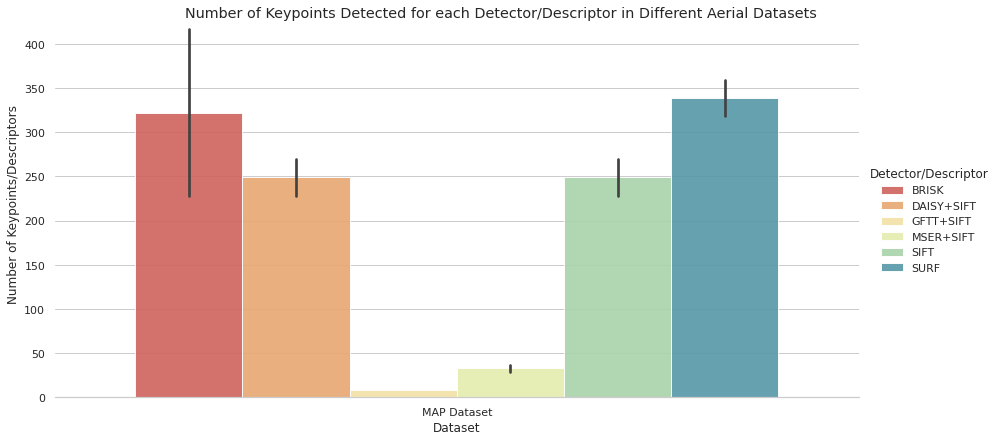

In [115]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_6, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [116]:
g.savefig(f'drive/MyDrive/Num_Kypoints_6_{Dataset}.png')

In [117]:
df_numkey_6.to_csv(f'drive/MyDrive/Num_Kypoints_6_{Dataset}.csv')

Total Number of Matches Detected for each Detector+Descriptor

In [118]:
#df_match_15['Number of Total Matches'] =  num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf+ num_matches_surfsift
d = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_matches_brisk + num_matches_daisy  + num_matches_gftt + num_matches_mser + num_matches_sift + num_matches_surf, 'Detector/Descriptor': ['BRISK']*(len_files-1) + ['DAISY+SIFT']*(len_files-1) + ['GFTT+SIFT']*(len_files-1) + ['MSER+SIFT']*(len_files-1) + ['SIFT']*(len_files-1) +  ['SURF']*(len_files-1) }
df_match_6 = pd.DataFrame(data=d)
df_match_6['Number of Total Matches'] = df_match_6['Number of Total Matches']/(len_files-1)

Text(0.5, 0.98, 'Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets')

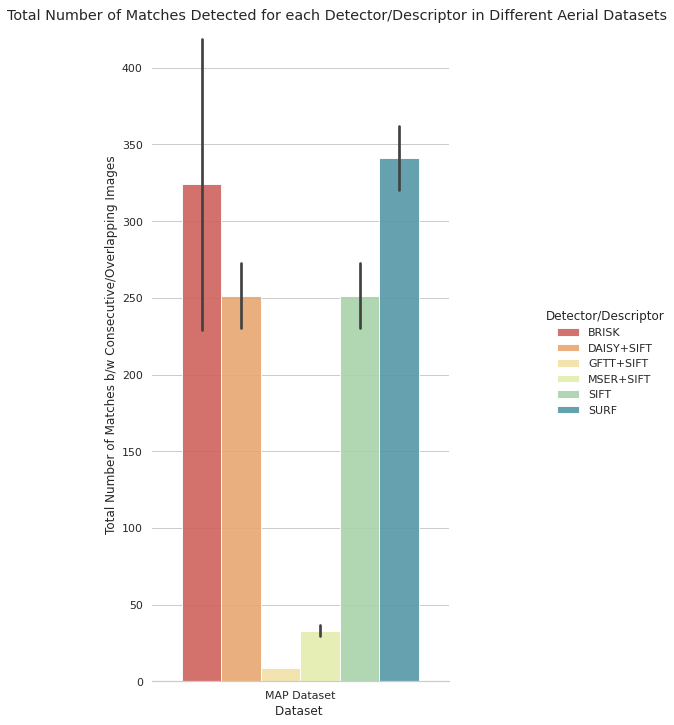

In [119]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_6, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset ", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [120]:
g.savefig(f'drive/MyDrive/Num_Matches_6_{Dataset}.png')

Total Number of Good/Robust Matches (NN+Lowe+RANSAC) Detected for each Detector+Descriptor

In [121]:
df_match_6['Number of Good Matches'] = num_good_matches_brisk + num_good_matches_daisy + num_good_matches_gftt + num_good_matches_mser + num_good_matches_sift + num_good_matches_surf
df_match_6['Number of Good Matches'] = df_match_6['Number of Good Matches']/(len_files-1)

Text(0.5, 0.98, 'Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets')

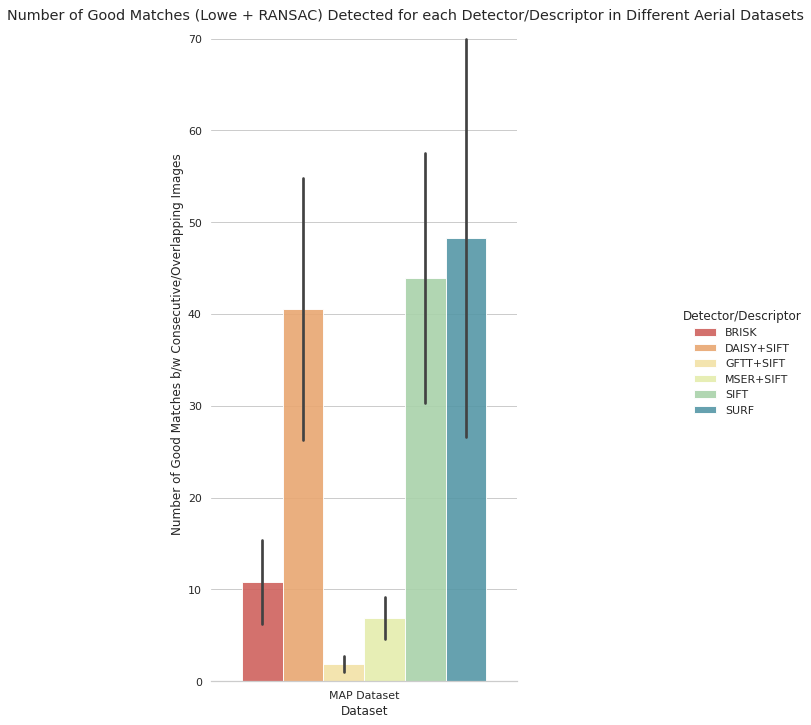

In [122]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_6, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [123]:
g.savefig(f'drive/MyDrive/Num_Good_Matches_6_{Dataset}.png')

Recall Rate for each Detector+Descriptor

In [124]:
df_match_6['Recall Rate of Matches'] = df_match_6['Number of Good Matches']/df_match_6['Number of Total Matches']

Text(0.5, 0.98, 'Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

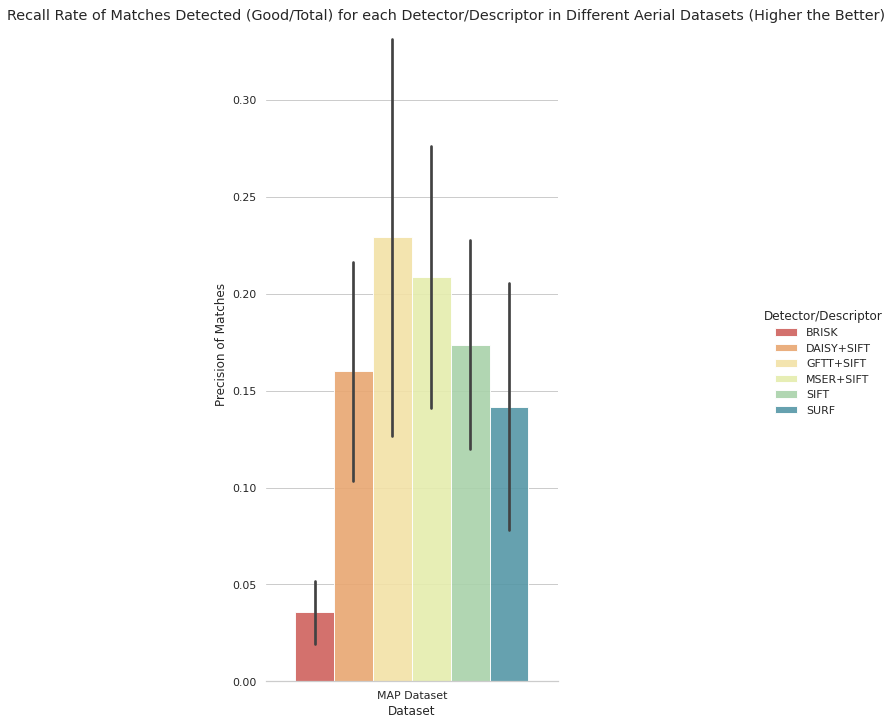

In [125]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_6, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [126]:
g.savefig(f'drive/MyDrive/Recall_Rate_Matches_6_{Dataset}.png')

1-Precision Rate for each Detector+Descriptor

In [127]:
df_match_6['1 - Precision Rate of Matches'] = (df_match_6['Number of Total Matches'] - df_match_6['Number of Good Matches'])/df_match_6['Number of Total Matches']

Text(0.5, 0.98, '1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

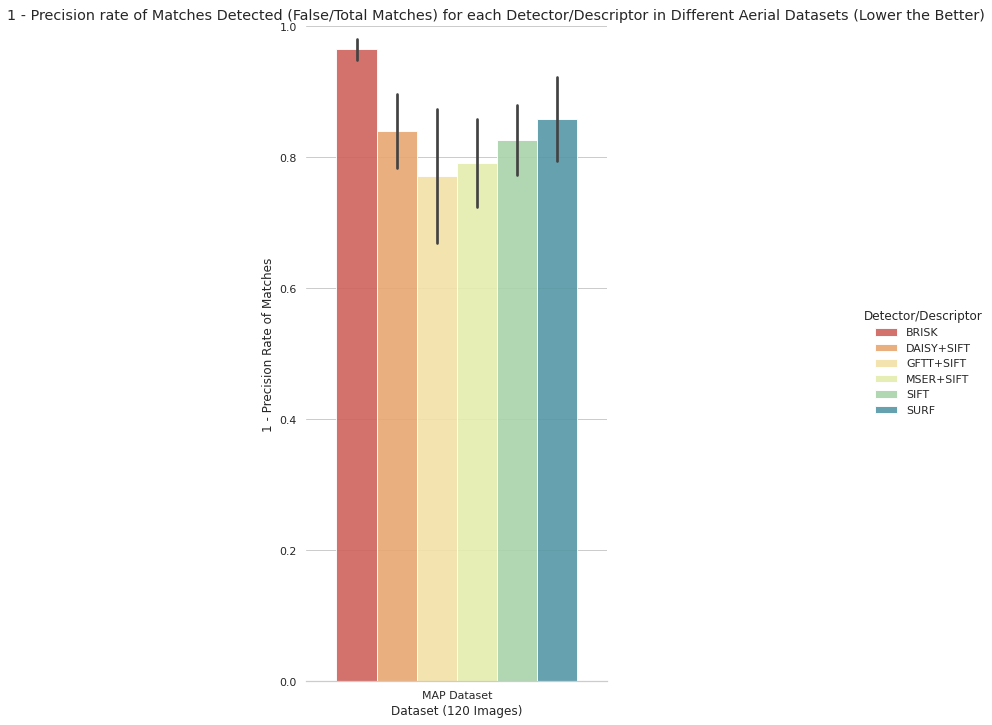

In [128]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_6, kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (120 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [129]:
g.savefig(f'drive/MyDrive/One_minus_Precision_Rate_Matches_6_{Dataset}.png')

F-Score for each Detector+Descriptor

In [130]:
df_match_6['F-Score'] = (2* (1 - df_match_6['1 - Precision Rate of Matches']) * df_match_6['Recall Rate of Matches'])/((1 - df_match_6['1 - Precision Rate of Matches']) + df_match_6['Recall Rate of Matches'])

Text(0.5, 0.98, 'F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

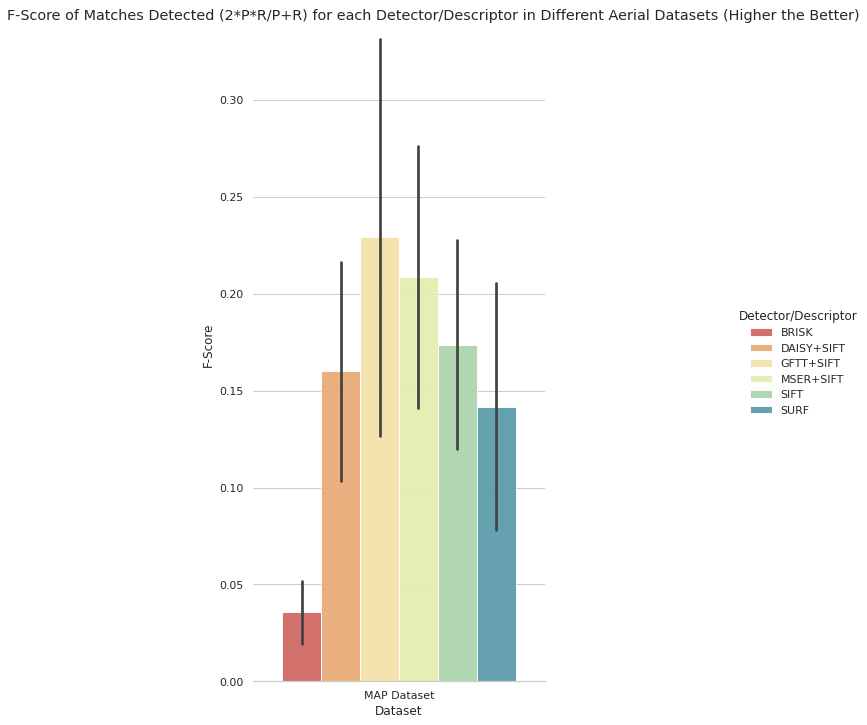

In [131]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_6, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [132]:
g.savefig(f'drive/MyDrive/F_Score_Rate_Matches_6_{Dataset}.png')

In [133]:
df_match_6.to_csv(f'drive/MyDrive/All_metrics_6_{Dataset}.csv')

Time for each Detector+Descriptor

In [134]:
d = {'Dataset': [f'{Dataset}']*(num_detectors), 'Time':  [time_all[3]] + [time_all[0]] + [time_all[5]] + [time_all[2]] + [time_all[1]]+ [time_all[4]] , 'Detector/Descriptor': ['BRISK']*(1) + ['DAISY+SIFT']*(1) + ['GFTT+SIFT']*(1) + ['MSER+SIFT']*(1) +['SIFT']*(1) + ['SURF']*(1)} 
df_time_6 = pd.DataFrame(data=d)

Text(0.5, 0.98, 'Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

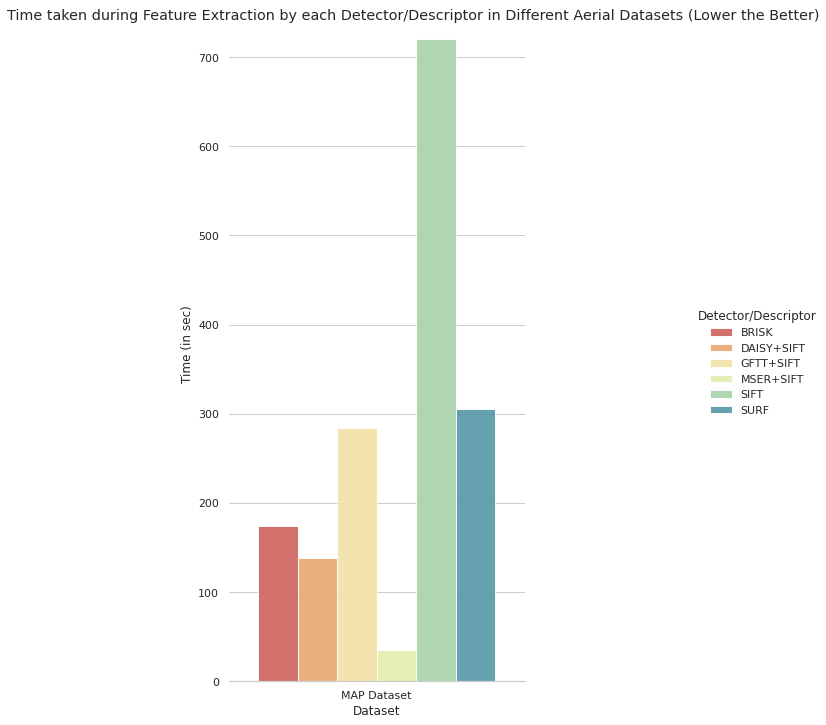

In [135]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_time_6, kind="bar",
    x="Dataset", y="Time", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Time (in sec)")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [136]:
g.savefig(f'drive/MyDrive/Time_6_{Dataset}.png')

In [137]:
df_time_6.to_csv(f'drive/MyDrive/Time_6_{Dataset}.csv')